#### Prepared for Prediction with Machine Learning course

This notebook uses code from AI and Gabor's case studies.

# Assignment Overview

The goal of this assignment is to predict which firms are likely to become high-growth using firm-level data from the Bisnode panel (2010–2015). We use a 2012 cross-section to train machine learning models and evaluate their performance in identifying high-growth firms in the following year.

All required libraries need to be installed before running the script.

The following command could be run if needed:

In [1]:
# !pip install numpy pandas regex statsmodels mizani plotnine

In [2]:
# !pip install --upgrade scikit-learn

In [3]:
# import os
# import sys
# import warnings

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import patsy
# import sklearn.metrics as metrics
# import statsmodels.formula.api as smf
# from plotnine import *
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import (
#     LinearRegression,
#     LogisticRegression,
#     LogisticRegressionCV,
# )
# from sklearn.metrics import (
#     auc,
#     brier_score_loss,
#     confusion_matrix,
#     mean_squared_error,
#     roc_auc_score,
#     roc_curve,
# )
# from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from sklearn.preprocessing import StandardScaler
# from statsmodels.tools.eval_measures import rmse

# warnings.filterwarnings("ignore")

In [4]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from plotnine import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")


In [5]:
# Get the current working directory
current_path = os.getcwd()

# Define relative paths for data, output, and helper functions
data_in = os.path.join(current_path, "data")       # Folder with input data
output = os.path.join(current_path, "output")      # Folder for saving results
func = os.path.join(current_path, "helpers")       # Folder with helper functions

# Ensure required folders exist
for folder in [data_in, output, func]:
    os.makedirs(folder, exist_ok=True)  # Creates the folder if it doesn't exist

# Add helper functions folder to Python's module search path
sys.path.append(func)

# Import helper functions if the helpers folder exists
try:
    from py_helper_functions import *
except ModuleNotFoundError:
    print("Warning: py_helper_functions.py not found in helpers/")


# Import data

In [6]:
csv_path = os.path.join(data_in, "cs_bisnode_panel.csv")

#data = pd.read_csv(csv_path)
data = pd.read_csv("https://osf.io/download/3qyut/")
data.shape

(287829, 48)

In [7]:
# restrict to panel for 2010-2015
data = data.query("year >= 2009 and year <= 2015")
# include 2009 for data exploration when choosing target variable
data.shape

(193202, 48)

In [8]:
# check missing values
def missing_value_summary(df):
    columns_with_nans = [col for col in df.columns if df[col].isnull().any()]
    missing_counts = df[columns_with_nans].isnull().sum().sort_values(ascending=False)
    return missing_counts

missing_value_summary(data)

D                    193202
finished_prod        182679
wages                182530
COGS                 182343
net_dom_sales        182343
net_exp_sales        182343
exit_year            170887
exit_date            165473
labor_avg             61599
birth_year            55298
founded_year          23909
ceo_count             23902
origin                23902
gender                23902
inoffice_days         23902
female                23902
foreign               23902
ind                    5791
material_exp           5250
personnel_exp          5250
amort                  5250
extra_profit_loss      4818
extra_inc              4814
extra_exp              4814
inc_bef_tax            4805
sales                  4805
region_m                534
nace_main                88
ind2                     88
profit_loss_year         81
curr_liab                71
intang_assets            71
tang_assets              71
share_eq                 71
fixed_assets             71
liq_assets          

In [9]:
data = data.dropna(subset=['sales'])
data = data[data['sales'] > 0] 

In [10]:
# drop variables with many NAs
data = data.drop(
    columns=["D", "COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

In [11]:
data.dtypes

comp_id                 float64
begin                    object
end                      object
amort                   float64
curr_assets             float64
curr_liab               float64
extra_exp               float64
extra_inc               float64
extra_profit_loss       float64
fixed_assets            float64
inc_bef_tax             float64
intang_assets           float64
inventories             float64
liq_assets              float64
material_exp            float64
personnel_exp           float64
profit_loss_year        float64
sales                   float64
share_eq                float64
subscribed_cap          float64
tang_assets             float64
balsheet_flag             int64
balsheet_length           int64
balsheet_notfullyear      int64
year                      int64
founded_year            float64
exit_year               float64
ceo_count               float64
foreign                 float64
female                  float64
birth_year              float64
inoffice


# Label engineering


In [12]:
# add all missing year and comp_id combinations -
# originally missing combinations will have NAs in all other columns
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan)  # only way I could define it as NaN


In [13]:
data.head(2)

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,2009,1001034.0,2009-01-01,2009-12-31,207.40741,5137.037109,15300.000000,0.0,0.0,0.0,...,mix,Domestic,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333
1,2009,1001541.0,2009-01-01,2009-12-31,0.00000,2040.740723,933.333313,0.0,0.0,0.0,...,male,Domestic,5610.0,56.0,3.0,3.0,Central,2008-02-24,NaN,NaN


In [14]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)


In [15]:
# Step 1: Filter for years when firms were alive
alive_data = data[data["status_alive"] == 1].copy()

# Step 2: For each company, get the first year they were alive
first_alive_year = alive_data.groupby("comp_id")["year"].min().reset_index()
first_alive_year.columns = ["comp_id", "first_alive_year"]

# Step 3: Merge this info back to the main data
alive_data = alive_data.merge(first_alive_year, on="comp_id", how="left")

# Step 4: Create a flag for the first alive year (i.e., when firm is "newly" alive)
alive_data["is_new_firm"] = (alive_data["year"] == alive_data["first_alive_year"]).astype(int)

# Step 5: Count total alive and new firms per year
alive_counts = alive_data.groupby("year")["comp_id"].nunique().reset_index(name="alive_companies_count")
new_counts = alive_data[alive_data["is_new_firm"] == 1].groupby("year")["comp_id"].nunique().reset_index(name="new_companies_count")

# Step 6: Merge both
summary = alive_counts.merge(new_counts, on="year", how="left").fillna(0)
summary["new_companies_count"] = summary["new_companies_count"].astype(int)

# Done
print(summary)



   year  alive_companies_count  new_companies_count
0  2009                  21615                21615
1  2010                  22303                 3352
2  2011                  22809                 3211
3  2012                  22845                 2640
4  2013                  22635                 2299
5  2014                  22352                 2026
6  2015                  22034                 1714


In [16]:
data["sales"].describe()

count    1.565930e+05
mean     5.630507e+05
std      4.172350e+06
min      2.111111e-01
25%      1.367778e+04
50%      4.314815e+04
75%      1.396889e+05
max      1.110294e+08
Name: sales, dtype: float64

In [17]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
)  # has to be outside of assin()
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)


In [18]:
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)


In [19]:
# replace w 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)


In [20]:
data["new"].describe()


count    257999.000000
mean          0.612654
std           0.487145
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64

In [21]:
data["age"].describe()

count    139734.000000
mean          9.071464
std           6.974391
min           0.000000
25%           3.000000
50%           8.000000
75%          15.000000
max          63.000000
Name: age, dtype: float64

# Target Definition & Economic Intuition

## Corporate Finance Motivation for Target Choice

We define fast growth based on a one-year percentage change in sales, aligning with the OECD standard for high-growth enterprises. From a corporate finance perspective, short-term revenue expansion reflects a firm’s ability to generate and scale operations efficiently, often signaling strong demand, effective reinvestment of earnings, and operational leverage. Using a 1-year window captures more immediate performance dynamics and supports timely decision-making for investors or lenders who seek early indicators of growth potential. Longer horizons risk introducing noise from market cycles or external shocks, reducing predictive clarity.

## Designing target variable

### Exploration

We aim to compare three types of sales growth measures:

1-year growth: The percentage change in sales over a single year (e.g., 2011 to 2012).

2-year growth: The percentage change in sales over a two-year period (e.g., 2012 compared to 2010).

Average 1-year growth over 2 years: The average of two consecutive 1-year growth rates (e.g., average of growth from 2010–2011 and 2011–2012).

#### Method 1: **year-over-year percentage change in sales**

**Growth rate** is calculated as the **forward-looking change in sales**, i.e., how much a firm’s sales increase (or decrease) in the **next year** relative to the current year

This threshold is based on [OECD](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:High-growth_enterprise) definition and it reflects a substantial year-over-year expansion.

In [22]:
# Sort by firm and year
data = data.sort_values(["comp_id", "year"])

# Calculate forward-looking growth rate (future sales vs. this year)
data["growth_rate"] = data.groupby("comp_id")["sales"].shift(-1) / data["sales"] - 1

# Replace inf, -inf with NaN to avoid polluting calculations
data['growth_rate'] = data['growth_rate'].replace([np.inf, -np.inf], np.nan)

In [23]:
# Step 1: Filter out the 99th percentile of growth rates
growth_rate_99th_percentile = data['growth_rate'].quantile(0.99)
data_filtered = data[data['growth_rate'] <= growth_rate_99th_percentile]

# Step 2: Define high-growth firms (growth > 20%)
data_filtered['HG_turnover'] = (data_filtered['growth_rate'] > 0.2).astype(int)

In [24]:
# Step 2.1: Create a shifted HG column to track previous year's status
data_filtered["HG_turnover_prev"] = data_filtered.groupby("comp_id")["HG_turnover"].shift(1)

# Step 2.2: Define transitions
data_filtered["HG_entry"] = np.where(
    (data_filtered["HG_turnover_prev"] == 0) & (data_filtered["HG_turnover"] == 1), 1, 0)

data_filtered["HG_exit"] = np.where(
    (data_filtered["HG_turnover_prev"] == 1) & (data_filtered["HG_turnover"] == 0), 1, 0)

# Step 3: Summarize transitions and growth metrics by year
hg_summary = data_filtered.groupby('year').apply(
    lambda x: pd.Series({
        'num_firms': x['comp_id'].nunique(),
        'hg_firms_share_percentage_next_period': (x['HG_turnover'].sum() / x['comp_id'].nunique()) * 100,
        'avg_growth_rate_hg': x.loc[x['HG_turnover'] == 1, 'growth_rate'].mean(),
        'avg_growth_rate_non_hg': x.loc[x['HG_turnover'] == 0, 'growth_rate'].mean(),
        'hg_entry_count': x['HG_entry'].sum(),
        'hg_exit_count': x['HG_exit'].sum(),
        'hg_entry_share_percentage': (x['HG_entry'].sum() / x['comp_id'].nunique()) * 100,
        'hg_exit_share_percentage': (x['HG_exit'].sum() / x['comp_id'].nunique()) * 100
    })
).reset_index()

# Step 4: Clean up the table
pretty_hg_summary = (
    hg_summary
    .rename(columns={
        'year': 'Year',
        'num_firms': 'Firms',
        'hg_firms_share_percentage_next_period': 'HG Share (%)',
        'avg_growth_rate_hg': 'Avg Growth (HG)',
        'avg_growth_rate_non_hg': 'Avg Growth (Non-HG)',
        'hg_entry_count': 'HG Entries',
        'hg_exit_count': 'HG Exits',
        'hg_entry_share_percentage': 'Entry Share (%)',
        'hg_exit_share_percentage': 'Exit Share (%)'
    })
    .round({
        'HG Share (%)': 2,
        'Avg Growth (HG)': 2,
        'Avg Growth (Non-HG)': 2,
        'Entry Share (%)': 2,
        'Exit Share (%)': 2
    })
)

# Convert count columns to integers
for col in ['Firms', 'HG Entries', 'HG Exits']:
    pretty_hg_summary[col] = pretty_hg_summary[col].astype(int)

# Display nicely
from IPython.display import display
display(pretty_hg_summary)

,Year,Firms,HG Share (%),Avg Growth (HG),Avg Growth (Non-HG),HG Entries,HG Exits,Entry Share (%),Exit Share (%)
0,2009,18709,28.26,2.23,-0.20,0,0,0.00,0.00
1,2010,19100,32.10,2.05,-0.18,2859,3239,14.97,16.96
2,2011,19640,29.89,2.08,-0.20,2553,4060,13.00,20.67
3,2012,19703,32.08,1.98,-0.18,3158,3708,16.03,18.82
4,2013,19728,36.97,1.78,-0.16,3684,3707,18.67,18.79
5,2014,19711,33.80,1.65,-0.14,3210,4626,16.29,23.47


### For comparison: Methods 2 and 3

#### Method 2: percentage change in sales over a two-year period

This method measures a firm's sales growth from year *t* to *t+2* as a percentage change.

A firm is classified as high-growth if this two-year growth exceeds 20%.

In [25]:
# Step 1: Sort data and calculate forward-looking 2-year growth
data = data.sort_values(['comp_id', 'year'])

# Growth from year t to t+2
data['growth_rate_t_to_t_plus_2'] = data.groupby('comp_id')['sales'].shift(-2) / data['sales'] - 1

# Replace inf/-inf with NaN
data['growth_rate_t_to_t_plus_2'] = data['growth_rate_t_to_t_plus_2'].replace([np.inf, -np.inf], np.nan)

# Step 2: Remove extreme values (winsorize at 99th percentile)
p99 = data['growth_rate_t_to_t_plus_2'].quantile(0.99)
data_filtered = data[data['growth_rate_t_to_t_plus_2'] <= p99]

# Step 3: Define high-growth firms (20% growth over 2 years)
data_filtered['high_growth_firm'] = (data_filtered['growth_rate_t_to_t_plus_2'] > 0.2).astype(int)

# Step 4: Aggregate by year (based on current year t)
result = data_filtered.groupby('year').apply(
    lambda x: pd.Series({
        'num_firms': x['comp_id'].nunique(),
        'hg_firms_share_percentage': (x['high_growth_firm'].sum() / x['comp_id'].nunique()) * 100,
        'avg_growth_rate_hg': x.loc[x['high_growth_firm'] == 1, 'growth_rate_t_to_t_plus_2'].mean(),
        'avg_growth_rate_non_hg': x.loc[x['high_growth_firm'] == 0, 'growth_rate_t_to_t_plus_2'].mean()
    })
).reset_index()

# Step 5: Label the approach
result['approach'] = 'per_2_year'

# Step 6: Display final result
from IPython.display import display
display(result)


,year,num_firms,hg_firms_share_percentage,avg_growth_rate_hg,avg_growth_rate_non_hg,approach
0,2009,16775.0,33.698957,2.952986,-0.257597,per_2_year
1,2010,17152.0,35.680970,2.870223,-0.263967,per_2_year
2,2011,17553.0,36.859796,2.899975,-0.257321,per_2_year
3,2012,17740.0,43.263811,2.541637,-0.228713,per_2_year
4,2013,18001.0,45.908561,2.445419,-0.206262,per_2_year


! 2-Year growth of High-Growth firms is higher than their 1-Year growth

While the 2-year growth measure can highlight firms with more **sustained growth**, it also introduces certain challenges:

- **Lagged signal**: It may delay identifying high-growth firms until after two full years of data are available.
- **Data sensitivity**: Requires complete data across a longer time frame, increasing vulnerability to missing or inconsistent entries.
- **Inflated values**: The higher average growth may affect model calibration or threshold selection, especially in classification tasks.

#### Method 3 (additional): Average growth over two 1-year periods

In this approach, we define high-growth firms based on their **average sales growth across the next two years**. Specifically, for each firm-year `t`, we calculate:

- Growth from year `t` to `t+1`
- Growth from year `t+1` to `t+2`

We then take the **average** of these two growth rates to get a smoothed, forward-looking indicator of performance:

A firm is labeled **high-growth** if this average exceeds **20%**.

In [26]:
# Step 1: Sort by firm and year
data = data.sort_values(['comp_id', 'year'])

# Step 2: Create forward-looking 1-year and 2-year growths
data['growth_t_to_t1'] = data.groupby('comp_id')['sales'].shift(-1) / data['sales'] - 1
data['growth_t1_to_t2'] = data.groupby('comp_id')['sales'].shift(-2) / data.groupby('comp_id')['sales'].shift(-1) - 1

# Step 3: Average of two forward-looking 1-year growth rates
data['avg_growth_2yrs_forward'] = data[['growth_t_to_t1', 'growth_t1_to_t2']].mean(axis=1)

# Only keep rows where both forward-looking growth rates are available
data['avg_growth_2yrs_forward'] = data[['growth_t_to_t1', 'growth_t1_to_t2']].mean(axis=1, skipna=False)

# Step 4: Remove extreme values
p99 = data['avg_growth_2yrs_forward'].quantile(0.99)
data_filtered = data[data['avg_growth_2yrs_forward'] <= p99]

# Step 5: Define high-growth target
data_filtered['high_growth_firm'] = (data_filtered['avg_growth_2yrs_forward'] > 0.2).astype(int)

# Step 6: Group by current year to describe the target
result_2y_avg = data_filtered.groupby('year').apply(
    lambda x: pd.Series({
        'num_firms': x['comp_id'].nunique(),
        'hg_firms_share_percentage': (x['high_growth_firm'].sum() / x['comp_id'].nunique()) * 100,
        'avg_growth_rate_hg': x.loc[x['high_growth_firm'] == 1, 'avg_growth_2yrs_forward'].mean(),
        'avg_growth_rate_non_hg': x.loc[x['high_growth_firm'] == 0, 'avg_growth_2yrs_forward'].mean()
    })
).reset_index()

# Step 7: Tag the approach
result_2y_avg['approach'] = 'avg_growth_2x_1yr_forward'

# Done!
from IPython.display import display
display(result_2y_avg)

,year,num_firms,hg_firms_share_percentage,avg_growth_rate_hg,avg_growth_rate_non_hg,approach
0,2009,16440.0,28.418491,1.649868,-0.095491,avg_growth_2x_1yr_forward
1,2010,16852.0,29.883693,1.676212,-0.096110,avg_growth_2x_1yr_forward
2,2011,17278.0,30.877416,1.656146,-0.092175,avg_growth_2x_1yr_forward
3,2012,17504.0,35.186243,1.467276,-0.066894,avg_growth_2x_1yr_forward
4,2013,17761.0,35.943922,1.398965,-0.046852,avg_growth_2x_1yr_forward


Advantages:
- **Reduces noise** from short-term spikes or drops in sales
- **Captures sustained growth** over multiple years

Disadvantages:
- Requires data for **three consecutive years**, reducing usable sample size
- May **delay signal detection** — firms with sudden breakout growth may be missed

This method is especially useful when we care about **stable medium-term growth**, rather than one-off performance.

### Why We Focus on 2012 Transitions

We chose 2012 as our reference year to ensure a large enough sample while maintaining a balanced rate of high-growth entries and exits.

Rather than only looking at the share of high-growth firms, we analyze **transitions** — how many firms **enter or exit** the high-growth category. This helps capture the **dynamics and mobility** in firm performance over time.

# Data Preparation & Feature Engineering


We use the Bisnode firm-level panel dataset covering the years 2010 to 2015. For modeling, we extract a cross-section of firms active in 2012, as it provides the most complete coverage across key financial and organizational variables. The prediction target is based on turnover growth in the following year (2013). Basic filtering is applied to ensure non-missing outcomes and features.

Feature engineering includes grouping variables into financials, HR, and firm characteristics. We apply log and squared transformations, create dummies and one-hot encode categorical variables, and use flag variables to handle missing values and data quality issues.

All steps are documented in the full Jupyter notebook, available on our GitHub repository folder [here](https://github.com/ttanyay/data_analysis_3/tree/main/assignment3).

# Sample design

In [27]:
data.shape

(257999, 54)

In [28]:
# Calculate the growth rate of sales for the period before
data['growth_rate_before'] = data.groupby('comp_id')['sales'].pct_change(periods=-1)

# Replace inf, -inf with NaN to avoid polluting calculations
data['growth_rate_before'] = data['growth_rate_before'].replace([np.inf, -np.inf], np.nan)

# Display the first few rows to verify
data[['comp_id', 'year', 'sales', 'growth_rate_before']].head()

data['growth_rate_before'].isna().sum()

84161

In [29]:
# look at cross section
data = data.query("year==2012 & status_alive == 1")
# look at firms below 10m euro revenues and above 1000 euros
# data = data.query("sales_mil<=10 & sales_mil>=0.001")

In [30]:
data.shape

(22845, 55)

In [31]:
data['growth_rate'].describe()

count    19900.000000
mean         8.570647
std        698.840074
min         -0.999920
25%         -0.193075
50%          0.037295
75%          0.345677
max      97425.497876
Name: growth_rate, dtype: float64

In [32]:
growth_rate_99th_percentile = data['growth_rate'].quantile(0.99)
data = data[data['growth_rate'] <= growth_rate_99th_percentile]

In [33]:
data['growth_rate'].describe()

count    19701.000000
mean         0.507666
std          2.419315
min         -0.999920
25%         -0.196189
50%          0.034247
75%          0.327473
max         30.431515
Name: growth_rate, dtype: float64

In [34]:
data_prepared = data.copy()

# Feature engineering

In [35]:
# replace missing values 'ind' with 'ind2' (since ind2 is more broad at least)
data['ind'] = data['ind'].fillna(data['ind2'])

# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [36]:
data.groupby("ind2_cat").count()["comp_id"]


ind2_cat
20.0       51
26.0     1073
27.0      657
28.0     1915
29.0      317
30.0      168
32.0      134
33.0     1846
40.0      201
55.0     2184
56.0    10929
60.0      220
99.0        6
Name: comp_id, dtype: int64

In [37]:
# Firm characteristics
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [38]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]


flag_asset_problem
0.0    19685
1.0       11
Name: comp_id, dtype: int64

In [39]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [40]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()


count    1.969600e+04
mean     5.363056e+05
std      4.080028e+06
min      0.000000e+00
25%      7.676852e+03
50%      2.770370e+04
75%      1.118898e+05
max      2.087229e+08
Name: total_assets_bs, dtype: float64

In [41]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

In [42]:
# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

In [43]:
# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [44]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [45]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [46]:
# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)


In [47]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [48]:
# employment is a very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)


In [49]:
data["labor_avg"].describe()


count    16739.000000
mean         1.007726
std          4.604799
min          0.083333
25%          0.104167
50%          0.243056
75%          0.566667
max        190.000000
Name: labor_avg, dtype: float64

In [50]:
data["labor_avg_mod"].describe()


count    19701.000000
mean         1.007726
std          4.244528
min          0.083333
25%          0.131944
50%          0.319444
75%          1.007726
max        190.000000
Name: labor_avg_mod, dtype: float64

In [51]:
data = data.drop(["labor_avg"], axis=1)


In [52]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")

# define high-growth firms (growth > 20%)
data['HG_turnover'] = (data['growth_rate'] > 0.2).astype(int)
data["HG_turnover_f"] = data["HG_turnover"].astype("category")
data["HG_turnover_f"] = data["HG_turnover_f"].cat.rename_categories(["non_hg", "hg"])


In [53]:
data["HG_turnover_f"].value_counts()

HG_turnover_f
non_hg    13383
hg         6318
Name: count, dtype: int64

In [54]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


# Exploratory Analysis

## Exploratory Visualization 1: Firm Size and High-Growth Probability

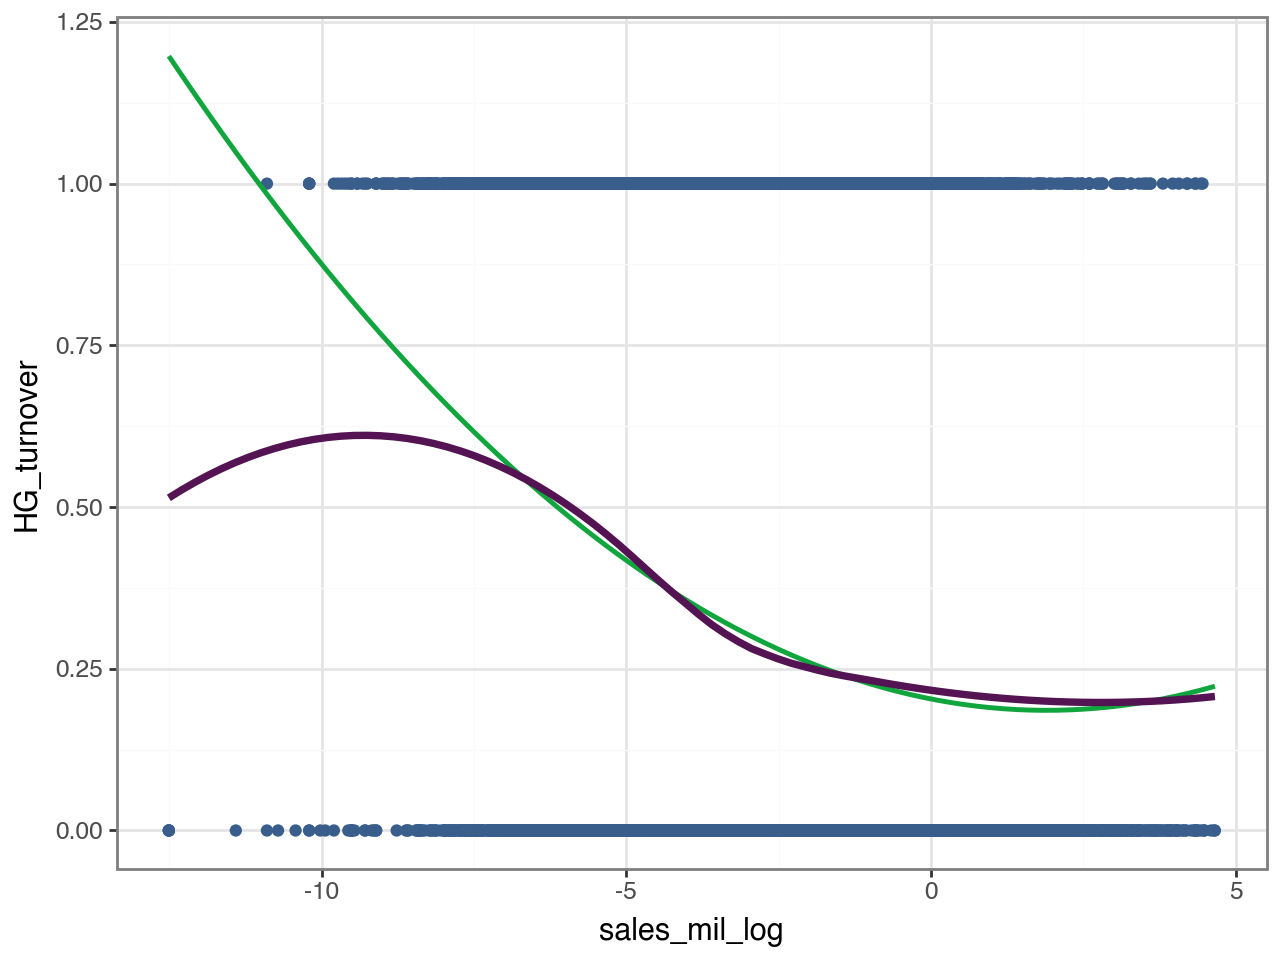

In [55]:
(
    ggplot(data, aes(x="sales_mil_log", y="HG_turnover"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="HG_turnover")
    + theme_bw()
)


The plot shows the relationship between firm size (sales_mil_log) and the likelihood of being high-growth (HG_turnover). The variable sales_mil_log represents the natural logarithm of firm sales in millions of euros, allowing for better handling of skewed distributions and relative differences between firm sizes.

Two trend lines are included: a quadratic regression line and a LOESS smoother. Both suggest a negative relationship — smaller firms are more likely to be classified as high-growth. This aligns with economic intuition: smaller firms typically have more room to scale rapidly, while larger firms tend to grow more incrementally.

Including both firm size (defined by sales volume) and its square as features in the model captures this nonlinearity effectively. Since sales_mil_log is based on 2012 values and the target measures growth in 2013, this relationship reflects a valid predictive signal and does not introduce target leakage.

In [56]:
# Linear regressions
ols_s = smf.ols("HG_turnover ~ profit_loss_year + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())


                            OLS Regression Results                            
Dep. Variable:            HG_turnover   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     406.5
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          1.06e-173
Time:                        23:13:26   Log-Likelihood:                -12542.
No. Observations:               19696   AIC:                         2.509e+04
Df Residuals:                   19693   BIC:                         2.511e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2287      0.005  

## Exploratory Visualization 2: Sales Growth and High-Growth Status

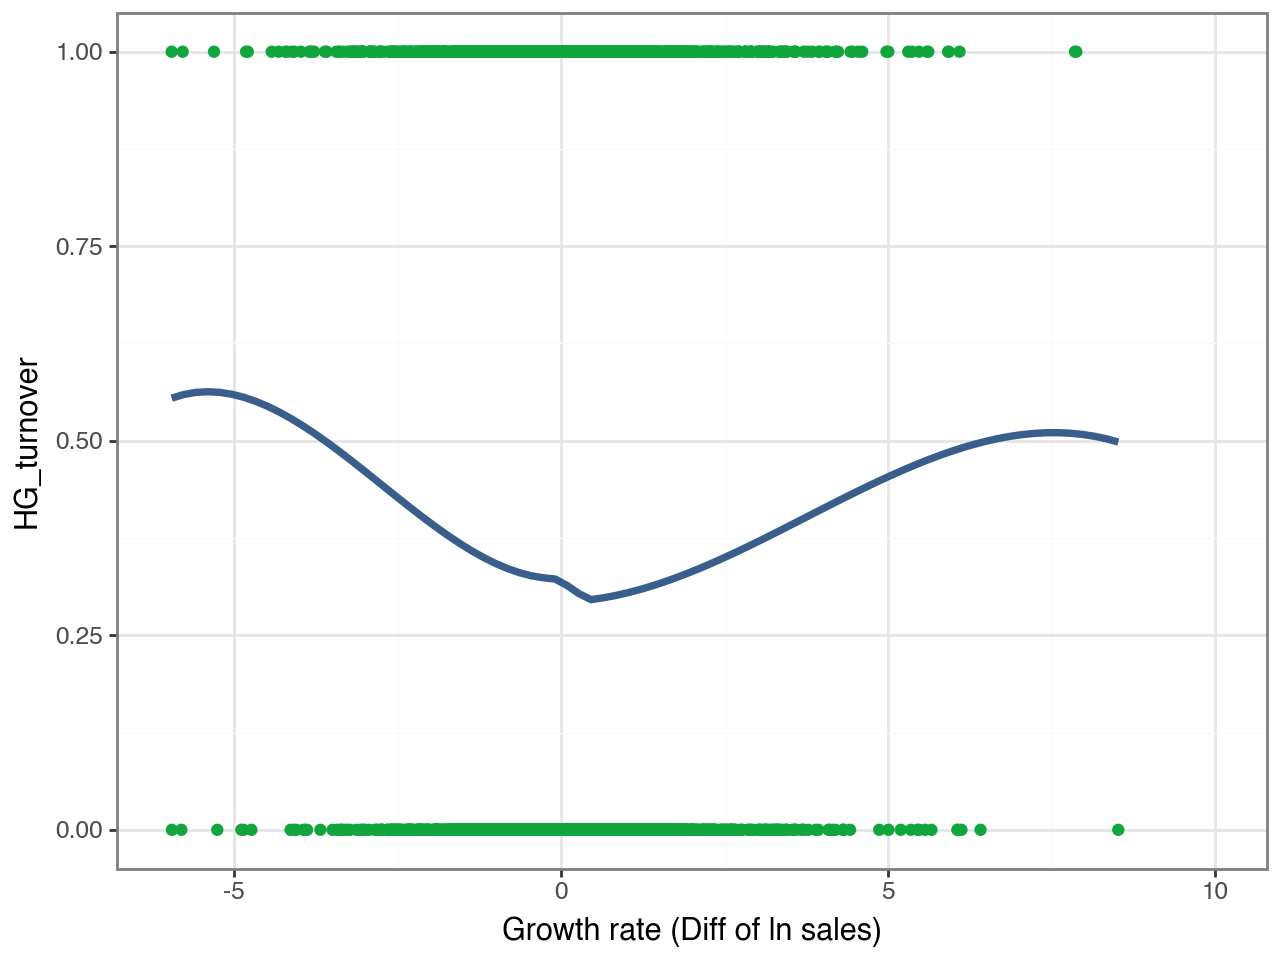

In [57]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="HG_turnover"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="HG_turnover")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)


The plot shows the relationship between recent sales growth (d1_sales_mil_log) and the probability of being classified as high-growth (HG_turnover). Each green dot represents a firm, while the blue line is a loess smoother capturing the trend.

Interestingly, the curve shows a nonlinear, U-shaped relationship. Firms with very low or very high past sales growth have a higher probability of being high-growth in the next year. In contrast, firms with moderate or near-zero growth show a lower probability. This suggests that both strong positive momentum and recovering firms (from very negative growth) may be more likely to scale.

This pattern is not driven by the 90th percentile cutoff used to define the high-growth label, as d1_sales_mil_log reflects past growth, while HG_turnover captures future outcomes. The relationship supports the inclusion of sales growth as a meaningful predictive feature, while also motivating the use of nonlinear models like Random Forest or Gradient Boosting.

In [58]:
data["d1_sales_mil_log"].describe()


count    19701.000000
mean         0.002805
std          0.639844
min         -6.846550
25%         -0.118706
50%          0.000000
75%          0.117298
max          8.522544
Name: d1_sales_mil_log, dtype: float64

In [59]:
data["profit_loss_year"].describe()


count    1.969600e+04
mean     7.003599e+03
std      2.640102e+05
min     -1.397323e+07
25%     -5.388889e+03
50%      1.407407e+02
75%      2.989815e+03
max      7.939082e+06
Name: profit_loss_year, dtype: float64

In [60]:
# generate variables [profit/loss] ---------------------------------------------------
data["profit_loss_year_mil"] = data["profit_loss_year"] / 1_000_000


In [61]:
# Then apply signed log transform
data["profit_loss_year_mil_log"] = (
    np.sign(data["profit_loss_year_mil"]) * np.log1p(np.abs(data["profit_loss_year_mil"]))
)

In [62]:
data["profit_loss_year_mil_log"].describe()

count    19696.000000
mean         0.004948
std          0.107133
min         -2.706264
25%         -0.005374
50%          0.000141
75%          0.002985
max          2.190433
Name: profit_loss_year_mil_log, dtype: float64

#### Profit / loss year --> transformed as log

Past profitability signals financial health and internal funding ability

Extreme profits/losses may reflect risk, investment strategy, or volatility

The log-transformed version keeps this nuance without letting giant numbers overwhelm the model

In [63]:
# Flag outliers (more extreme than ±0.2)
data["flag_low_profit_loss_year_mil_log"] = np.where(data["profit_loss_year_mil_log"] < -0.2, 1, 0)
data["flag_high_profit_loss_year_mil_log"] = np.where(data["profit_loss_year_mil_log"] > 0.2, 1, 0)

# Winsorize extreme values
data["profit_loss_year_mil_log_mod"] = np.where(
    data["profit_loss_year_mil_log"] < -0.2,
    -0.2,
    np.where(data["profit_loss_year_mil_log"] > 0.2, 0.2, data["profit_loss_year_mil_log"])
)

# Squared term
data["profit_loss_year_mil_log_mod_sq"] = data["profit_loss_year_mil_log_mod"] ** 2

In [64]:
# generate variables [d1 of sales] ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2


In [65]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "ind"])


In [66]:
missing_value_summary(data[["age", "foreign", "material_exp_pl", "m_region_loc"]])

age                1765
foreign            1763
m_region_loc         61
material_exp_pl      43
dtype: int64

In [67]:
# drop missing
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()


count    17837.000000
mean         9.159332
std          6.967644
min          0.000000
25%          3.000000
50%          8.000000
75%         15.000000
max         32.000000
Name: age, dtype: float64

In [68]:
# Create quadratic variables
quad_vars = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]
for var in quad_vars:
    data[f"{var}_quad"] = data[var] ** 2

In [69]:
data.to_csv(os.path.join(output, "2012_hg_workfile1.csv"), index=False)

In [70]:
# Manufacturing industry codes (NACE 10–33)
manufacturing_codes = list(range(10, 34))  # includes 25 to 33, etc.

# Services industry codes (specific NACE codes)
services_codes = [55, 56, 95]

# Create industry-specific datasets
data_manufacturing = data[data["ind2"].isin(manufacturing_codes)].copy()
data_services = data[data["ind2"].isin(services_codes)].copy()

# Sanity check
print("Manufacturing sample size:", data_manufacturing.shape[0])
print("Services sample size:", data_services.shape[0])

Manufacturing sample size: 5619
Services sample size: 11842


In [71]:
data_manufacturing.to_csv(os.path.join(output, "2012_hg_workfile_M.csv"), index=False) #manufacturing
data_services.to_csv(os.path.join(output, "2012_hg_workfile_S.csv"), index=False) #services

# PART 1

## Import data

In [72]:
# !!! assignment-3-prep.ipynb should be run first

# Import data
csv_path = os.path.join(output, "2012_hg_workfile1.csv")

# Read the CSV file
data = pd.read_csv(csv_path)

In [73]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,profit_loss_year_mil,profit_loss_year_mil_log,flag_low_profit_loss_year_mil_log,flag_high_profit_loss_year_mil_log,profit_loss_year_mil_log_mod,profit_loss_year_mil_log_mod_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
count,17837.0,1.783700e+04,1.783700e+04,1.783700e+04,1.783700e+04,1.783700e+04,1.783700e+04,1.783700e+04,1.783700e+04,1.783700e+04,...,17837.000000,17837.000000,17837.000000,17837.000000,17837.000000,1.783700e+04,17837.000000,17837.000000,17837.000000,17837.000000
mean,2012.0,1.535843e+11,2.028789e+04,2.264459e+05,1.837608e+05,1.432753e+03,2.900909e+03,1.464466e+03,2.530140e+05,1.744949e+04,...,0.006776,0.004706,0.006728,0.016090,0.001957,1.590654e-03,0.019286,0.021921,-0.003158,0.232988
std,0.0,1.377655e+11,1.574587e+05,1.698885e+06,1.705054e+06,4.876899e+04,6.697546e+04,4.586052e+04,2.054541e+06,2.894010e+05,...,0.237016,0.101874,0.081748,0.125826,0.039836,6.623595e-03,0.137531,0.146429,0.482692,0.524350
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1.418519e+03,-1.740741e+02,-2.211578e+06,0.000000e+00,-1.397323e+07,...,-13.973230,-2.706264,0.000000,0.000000,-0.200000,0.000000e+00,0.000000,0.000000,-1.500000,0.000000
25%,2012.0,2.909642e+10,1.703704e+02,3.829630e+03,3.703704e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.222222e+02,-5.437037e+03,...,-0.005456,-0.005441,0.000000,0.000000,-0.005441,9.696345e-07,0.000000,0.000000,-0.151839,0.000612
50%,2012.0,1.150081e+11,1.074074e+03,1.293704e+04,1.504074e+04,0.000000e+00,0.000000e+00,0.000000e+00,6.166667e+03,3.962963e+02,...,0.000159,0.000159,0.000000,0.000000,0.000159,1.731974e-05,0.000000,0.000000,0.000000,0.021798
75%,2012.0,2.568352e+11,4.814815e+03,4.637778e+04,5.201482e+04,0.000000e+00,0.000000e+00,0.000000e+00,5.055185e+04,4.948148e+03,...,0.003130,0.003125,0.000000,0.000000,0.003125,1.779623e-04,0.000000,0.000000,0.144423,0.150633
max,2012.0,4.641050e+11,6.448699e+06,8.194425e+07,1.219722e+08,4.863126e+06,6.414444e+06,3.253704e+06,1.155504e+08,9.015152e+06,...,7.939082,2.190433,1.000000,1.000000,0.200000,4.000000e-02,1.000000,1.000000,1.500000,2.250000


## Define helper functions

In [74]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot


# Part 1: Full sample

## Model building

### Choice of models

We compare seven models: five logistic regressions of increasing complexity (M1–M5), a LASSO-regularized logistic model, a Random Forest (RF), and a Gradient Boosting Model (GBM). 

1. Logit - A standard baseline model for binary outcomes.
It is interpretable and widely used. LASSO adds automatic variable selection and helps avoid overfitting when there are many predictors.

2. Random Forest (RF) – A flexible, nonparametric method that captures complex patterns in the data.
It generally performs better than Logit in prediction tasks and doesn’t require model-building assumptions.

3. Gradient Boosting Model (GBM) – Builds trees in sequence, improving predictions step by step.
It is accurate and effective for both predicting probabilities and classifying outcomes.

### Define variable sets 

 Main firm variables

In [75]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [76]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

 Flag variables

In [77]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth variables

In [78]:
d1 = [
    "d1_sales_mil_log_mod",
    "d1_sales_mil_log_mod_sq",
    "flag_low_d1_sales_mil_log",
    "flag_high_d1_sales_mil_log",
]

Human capital related variables

In [79]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 Firms history related variables

In [80]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions for logit, LASSO

In [81]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

We constructed five sets of predictors (M1 to M5) with increasing complexity. 
- M1 includes only basic firm-level characteristics. Whereas each subsequent model adds more variables, such as financial ratios, sector dummies, or interaction terms.  
- This setup allows us to assess how model performance improves as we add more information.

Random Forest (RF) and Gradient Boosting Model (GBM) are trained on the full set of variables (equivalent to M5). These models can automatically capture interactions and nonlinear relationships, so no manual feature selection or transformation is needed. 

## Model setups

1. Simple logit models

In [82]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "d1_sales_mil_log_mod",
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = [    "sales_mil_log",   "sales_mil_log_sq"] + firm + engvar + d1
M4 = (
    [    "sales_mil_log",  "sales_mil_log_sq" ]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log",
    "sales_mil_log_sq"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. logit+LASSO

In [83]:
logit_lasso_vars = (
    ["sales_mil_log",
    "sales_mil_log_sq"]
    + engvar
    + engvar2
    + engvar3
    + d1
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [84]:
rfvars = ["sales_mil_log", "sales_mil_log_sq"] + rawvars + hr + firm + qualityvars

## Quick reminder about probability models

 Linear probability model

In [85]:
ols_modelx1 = smf.ols("HG_turnover~" + "+".join(M1), data).fit(cov_type="HC1")
ols_modelx1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            HG_turnover   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     53.11
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          1.95e-156
Time:                        23:13:29   Log-Likelihood:                -11163.
No. Observations:               17837   AIC:                         2.236e+04
Df Residuals:                   17821   BIC:                         2.248e+04
Df Model:                          15                                         
Covariance Type:                  HC1                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2450      0.065      3.782      0.000       0.118       0.372
C(ind2_cat)[T.26.0]     -0.0383      0.066     -0.578      0.563      -0.168       0.091
C(ind2_cat)[T.27.0]     -0.0381      0.067     -0.567      0.571      -0.170       0.094
C(ind2_cat)[T.28.0]     -0.0177      0.066     -0.270      0.787      -0.146       0.111
C(ind2_cat)[T.29.0]      0.0532      0.071      0.753      0.452      -0.085       0.192
C(ind2_cat)[T.30.0]      0.0042      0.076      0.055      0.956      -0.144       0.152
C(ind2_cat)[T.32.0]     -0.1333      0.076     -1.760      0.078      -0.282       0.015
C(ind2_cat)[T.33.0]     -0.0140      0.066     -0.213      0.831      -0.143       0.115
C(ind2_cat)[T.40.0]     -0.0115      0.073     -0.157      0.875      -0.155       0.132
C(ind2_cat)[T.55.0]     -0.0889      0.065     -1.360      0.174      -0.217       0.039
C(ind2_cat)[T.56.0]     -0.0784      0.065     -1.211      0.226      -0.205       0.049
C(ind2_cat)[T.60.0]     -0.0203      0.073     -0.278      0.781      -0.163       0.123
sales_mil_log           -0.0253      0.003     -7.273      0.000      -0.032      -0.018
sales_mil_log_sq         0.0033      0.001      5.448      0.000       0.002       0.004
d1_sales_mil_log_mod     0.0303      0.008      3.907      0.000       0.015       0.046
profit_loss_year_pl     -0.1111      0.011     -9.674      0.000      -0.134      -0.089
==============================================================================
Omnibus:                    14300.796   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2818.019
Skew:                           0.775   Prob(JB):                         0.00
Kurtosis:                       1.822   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
ols_modelx2 = smf.ols("HG_turnover~" + "+".join(M2), data).fit(cov_type="HC1")
ols_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            HG_turnover   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     59.43
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          2.15e-253
Time:                        23:13:30   Log-Likelihood:                -10942.
No. Observations:               17837   AIC:                         2.193e+04
Df Residuals:                   17814   BIC:                         2.211e+04
Df Model:                          22                                         
Covariance Type:                  HC1                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.3556      0.066      5.350      0.000       0.225       0.486
C(ind2_cat)[T.26.0]        -0.0359      0.067     -0.538      0.591      -0.167       0.095
C(ind2_cat)[T.27.0]        -0.0374      0.068     -0.551      0.582      -0.170       0.096
C(ind2_cat)[T.28.0]        -0.0199      0.066     -0.300      0.764      -0.150       0.110
C(ind2_cat)[T.29.0]         0.0394      0.071      0.553      0.580      -0.100       0.179
C(ind2_cat)[T.30.0]        -0.0035      0.076     -0.047      0.963      -0.152       0.145
C(ind2_cat)[T.32.0]        -0.1111      0.076     -1.456      0.145      -0.261       0.038
C(ind2_cat)[T.33.0]        -0.0409      0.066     -0.618      0.537      -0.171       0.089
C(ind2_cat)[T.40.0]        -0.0221      0.074     -0.300      0.765      -0.167       0.123
C(ind2_cat)[T.55.0]        -0.0968      0.066     -1.465      0.143      -0.226       0.033
C(ind2_cat)[T.56.0]        -0.1046      0.065     -1.597      0.110      -0.233       0.024
C(ind2_cat)[T.60.0]        -0.0274      0.073     -0.373      0.709      -0.171       0.117
sales_mil_log              -0.0190      0.004     -5.120      0.000      -0.026      -0.012
sales_mil_log_sq            0.0037      0.001      5.978      0.000       0.002       0.005
d1_sales_mil_log_mod        0.0128      0.008      1.637      0.102      -0.003       0.028
profit_loss_year_pl        -0.1121      0.012     -9.149      0.000      -0.136      -0.088
fixed_assets_bs            -0.0136      0.011     -1.239      0.215      -0.035       0.008
share_eq_bs                 0.0293      0.009      3.387      0.001       0.012       0.046
curr_liab_bs                0.0466      0.015      3.071      0.002       0.017       0.076
curr_liab_bs_flag_high     -0.0314      0.013     -2.335      0.020      -0.058      -0.005
curr_liab_bs_flag_error    -0.1289      0.136     -0.945      0.344      -0.396       0.138
age                        -0.0103      0.001    -19.224      0.000      -0.011      -0.009
foreign_management          0.0066      0.011      0.578      0.563      -0.016       0.029
==============================================================================
Omnibus:                     9252.689   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2601.383
Skew:                           0.752   Prob(JB):                         0.00
Kurtosis:                       1.889   Cond. No.                     1.26e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
logit_modelx2 = smf.logit("HG_turnover~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.585511
         Iterations 5


In [88]:
logit_modelx2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            HG_turnover   No. Observations:                17837
Model:                          Logit   Df Residuals:                    17814
Method:                           MLE   Df Model:                           22
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                 0.05579
Time:                        23:13:30   Log-Likelihood:                -10444.
converged:                       True   LL-Null:                       -11061.
Covariance Type:            nonrobust   LLR p-value:                2.213e-247
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.6326      0.314     -2.014      0.044      -1.248      -0.017
C(ind2_cat)[T.26.0]        -0.1585      0.315     -0.503      0.615      -0.776       0.459
C(ind2_cat)[T.27.0]        -0.1724      0.321     -0.537      0.591      -0.802       0.457
C(ind2_cat)[T.28.0]        -0.0784      0.311     -0.252      0.801      -0.689       0.532
C(ind2_cat)[T.29.0]         0.2359      0.334      0.706      0.480      -0.419       0.891
C(ind2_cat)[T.30.0]        -0.0089      0.354     -0.025      0.980      -0.702       0.685
C(ind2_cat)[T.32.0]        -0.5462      0.381     -1.435      0.151      -1.292       0.200
C(ind2_cat)[T.33.0]        -0.1960      0.311     -0.629      0.529      -0.806       0.414
C(ind2_cat)[T.40.0]        -0.1010      0.346     -0.291      0.771      -0.780       0.578
C(ind2_cat)[T.55.0]        -0.4772      0.311     -1.532      0.125      -1.087       0.133
C(ind2_cat)[T.56.0]        -0.5120      0.308     -1.663      0.096      -1.116       0.092
C(ind2_cat)[T.60.0]        -0.1277      0.343     -0.372      0.710      -0.799       0.544
sales_mil_log              -0.1161      0.021     -5.530      0.000      -0.157      -0.075
sales_mil_log_sq            0.0137      0.003      4.587      0.000       0.008       0.020
d1_sales_mil_log_mod        0.0579      0.036      1.631      0.103      -0.012       0.128
profit_loss_year_pl        -0.5040      0.056     -9.025      0.000      -0.613      -0.395
fixed_assets_bs            -0.0702      0.055     -1.283      0.199      -0.177       0.037
share_eq_bs                 0.1374      0.043      3.209      0.001       0.053       0.221
curr_liab_bs                0.2343      0.075      3.131      0.002       0.088       0.381
curr_liab_bs_flag_high     -0.1533      0.066     -2.339      0.019      -0.282      -0.025
curr_liab_bs_flag_error    -0.6801      0.836     -0.814      0.416      -2.319       0.958
age                        -0.0524      0.003    -18.831      0.000      -0.058      -0.047
foreign_management          0.0395      0.057      0.697      0.486      -0.072       0.151
===========================================================================================
"""

With Logit we need to calculate average marginal effects (dy/dx) to be able to interpret the coefficients (under some assumptions...)

In [89]:
logit_modelx2.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:            HG_turnover
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
C(ind2_cat)[T.26.0]        -0.0316      0.063     -0.503      0.615      -0.155       0.092
C(ind2_cat)[T.27.0]        -0.0344      0.064     -0.537      0.591      -0.160       0.091
C(ind2_cat)[T.28.0]        -0.0156      0.062     -0.252      0.801      -0.137       0.106
C(ind2_cat)[T.29.0]         0.0471      0.067      0.706      0.480      -0.084       0.178
C(ind2_cat)[T.30.0]        -0.0018      0.071     -0.025      0.980      -0.140       0.137
C(ind2_cat)[T.32.0]        -0.1090      0.076     -1.435      0.151      -0.258       0.040
C(ind2_cat)[T.33.0]        -0.0391      0.062     -0.629      0.529      -0.161       0.083
C(ind2_cat)[T.40.0]        -0.0201      0.069     -0.291      0.771      -0.156       0.115
C(ind2_cat)[T.55.0]        -0.0952      0.062     -1.533      0.125      -0.217       0.027
C(ind2_cat)[T.56.0]        -0.1022      0.061     -1.663      0.096      -0.223       0.018
C(ind2_cat)[T.60.0]        -0.0255      0.068     -0.372      0.710      -0.160       0.109
sales_mil_log              -0.0232      0.004     -5.543      0.000      -0.031      -0.015
sales_mil_log_sq            0.0027      0.001      4.599      0.000       0.002       0.004
d1_sales_mil_log_mod        0.0116      0.007      1.632      0.103      -0.002       0.025
profit_loss_year_pl        -0.1006      0.011     -9.101      0.000      -0.122      -0.079
fixed_assets_bs            -0.0140      0.011     -1.284      0.199      -0.035       0.007
share_eq_bs                 0.0274      0.009      3.213      0.001       0.011       0.044
curr_liab_bs                0.0468      0.015      3.134      0.002       0.018       0.076
curr_liab_bs_flag_high     -0.0306      0.013     -2.340      0.019      -0.056      -0.005
curr_liab_bs_flag_error    -0.1357      0.167     -0.814      0.416      -0.463       0.191
age                        -0.0104      0.001    -19.463      0.000      -0.012      -0.009
foreign_management          0.0079      0.011      0.697      0.486      -0.014       0.030
===========================================================================================
"""

## 0. Separate train and holdout data

In [90]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [91]:
print("Total")
print(data["HG_turnover"].value_counts(normalize=True))
print("Train")
print(data_train["HG_turnover"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["HG_turnover"].value_counts(normalize=True))


Total
HG_turnover
0    0.688737
1    0.311263
Name: proportion, dtype: float64
Train
HG_turnover
0    0.688696
1    0.311304
Name: proportion, dtype: float64
Holdout
HG_turnover
0    0.688901
1    0.311099
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [92]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [93]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [94]:
C_value_logit = [1e20]

In [95]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "HG_turnover~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [96]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.453674,0.448324,0.441399,0.439223,0.439766
1,0.453006,0.447705,0.443118,0.440257,0.440562
2,0.456544,0.449611,0.447823,0.444704,0.446635
3,0.451503,0.445823,0.439853,0.437845,0.438358
4,0.450207,0.444982,0.437950,0.435802,0.435067


### b) Logit + LASSO

In [97]:
model_equation = "HG_turnover~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [98]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [99]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [100]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [101]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000876,0.473713
1,0.046416,0.001887,0.453217
2,0.021544,0.004066,0.444684
3,0.010000,0.008760,0.441233
4,0.004642,0.018873,0.439632
5,0.002154,0.040661,0.439533
6,0.001000,0.087602,0.439746
7,0.000464,0.188734,0.440259
8,0.000215,0.406615,0.440731
9,0.000100,0.876025,0.441169


Save best lambda's index for later use

In [102]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [103]:
best_lambda_i

5

Extract CV test RMSE for the Lasso with best lambda

In [104]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [105]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "HG_turnover~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [106]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [107]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [108]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

101

In [109]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

101

In [110]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,16,0.452987,0.618541
M2,23,0.447289,0.651345
M3,40,0.442029,0.672425
M4,83,0.439566,0.676471
M5,197,0.440077,0.676408
LASSO,101,0.439519,0.677835


In [111]:
best_logit = logit_models["M4"]
model_equation = "HG_turnover~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [112]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["HG_turnover"]), 3)

0.438

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


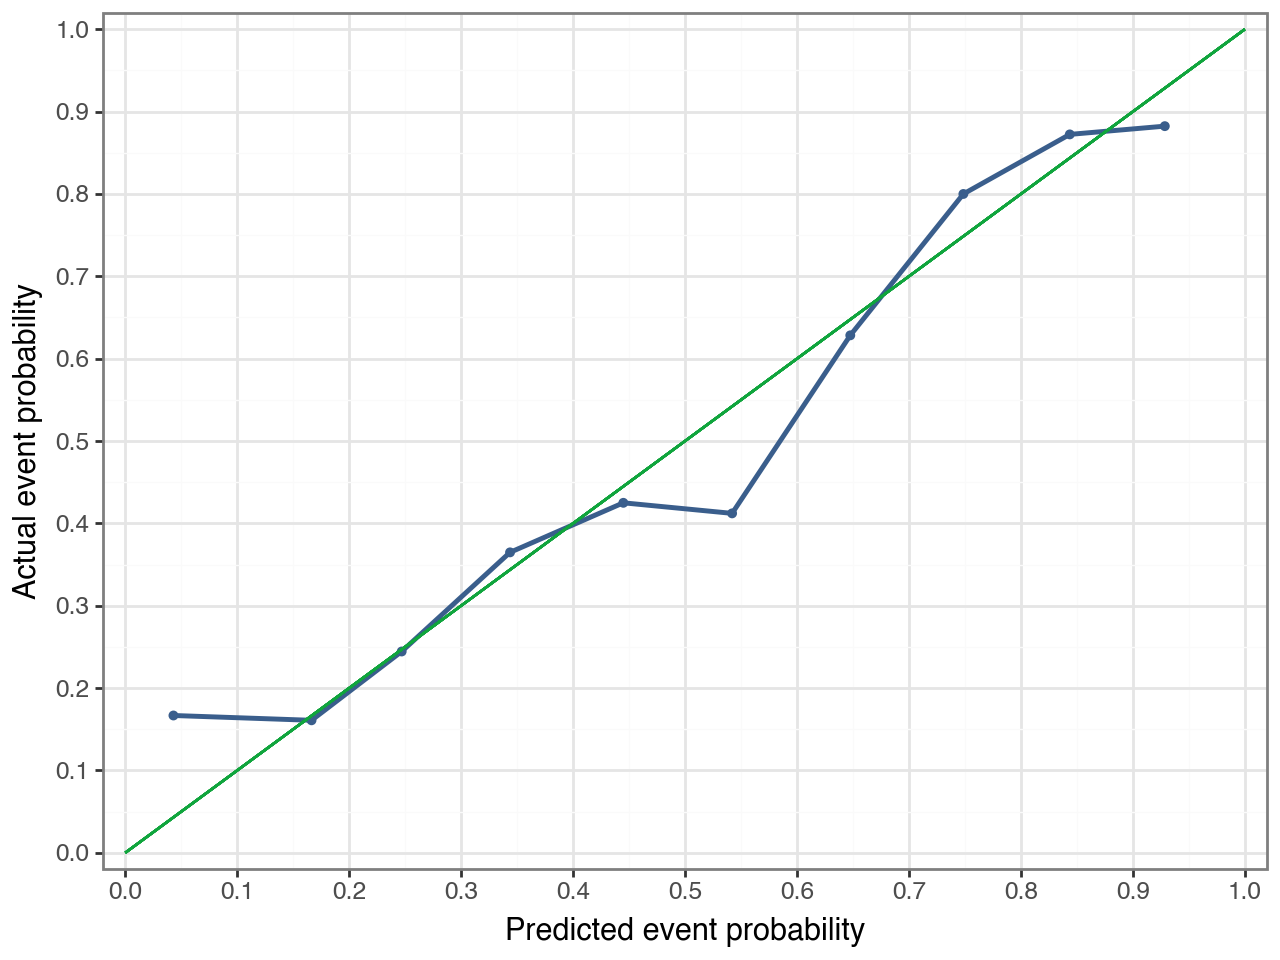

In [113]:
create_calibration_plot(
    data_holdout,
    file_name="da3-a3-logit-m4-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="HG_turnover",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)

This plot shows how well the predicted probabilities match actual outcomes. The model is reasonably well calibrated, especially in the mid-to-high probability range. It is important to point out that it tends to be slightly underconfident when it predicts a high chance of success, the real success rate is often even higher.  

This is a good sign: the model is cautious rather than overconfident. It suggests that in high-probability cases, we can trust the predictions even more than the model does.  


### b) Confusion table with different thresholds

Default: the threshold 0.5 is used to convert probabilities to binary classes

In [114]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (non high-growth): ", counts[0])
print(values[1], " (high-growth): ", counts[1])

0.0  (non high-growth):  3156
1.0  (high-growth):  412


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [115]:
cm_object1 = confusion_matrix(
    data_holdout["HG_turnover"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)
cm1

,Predicted non-HG,Predicted HG
Actul non-HG,2297,161
Actual HG,859,251


In [116]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

thresholds = [0.5, 0.4, 0.35, 0.3]
for t in thresholds:
    preds = np.where(data_holdout["best_logit_pred_proba"] >= t, 1, 0)
    cm = confusion_matrix(data_holdout["HG_turnover"], preds, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n--- Threshold: {t} ---")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision (HG): {precision_score(data_holdout['HG_turnover'], preds):.3f}")
    print(f"Recall (HG):    {recall_score(data_holdout['HG_turnover'], preds):.3f}")
    print(f"False Negatives (missed HGs): {fn}")
    print(f"False Positives: {fp}")



--- Threshold: 0.5 ---
Confusion Matrix:
[[2297  161]
 [ 859  251]]
Precision (HG): 0.609
Recall (HG):    0.226
False Negatives (missed HGs): 859
False Positives: 161

--- Threshold: 0.4 ---
Confusion Matrix:
[[2071  387]
 [ 692  418]]
Precision (HG): 0.519
Recall (HG):    0.377
False Negatives (missed HGs): 692
False Positives: 387

--- Threshold: 0.35 ---
Confusion Matrix:
[[1878  580]
 [ 583  527]]
Precision (HG): 0.476
Recall (HG):    0.475
False Negatives (missed HGs): 583
False Positives: 580

--- Threshold: 0.3 ---
Confusion Matrix:
[[1613  845]
 [ 429  681]]
Precision (HG): 0.446
Recall (HG):    0.614
False Negatives (missed HGs): 429
False Positives: 845


In [117]:
# Applying different thresholds

holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.4, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["HG_turnover"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)
cm1b

,Predicted non-HG,Predicted HG
Actul non-HG,2071,387
Actual HG,692,418


A sensible choice: mean of predicted probabilities

In [118]:
mean_predicted_default_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_default_prob, 3)

0.316

In [119]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["HG_turnover"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)
cm2

,Predicted non-HG,Predicted HG
Actul non-HG,1720,738
Actual HG,487,623


### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [120]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these threshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["HG_turnover"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [121]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

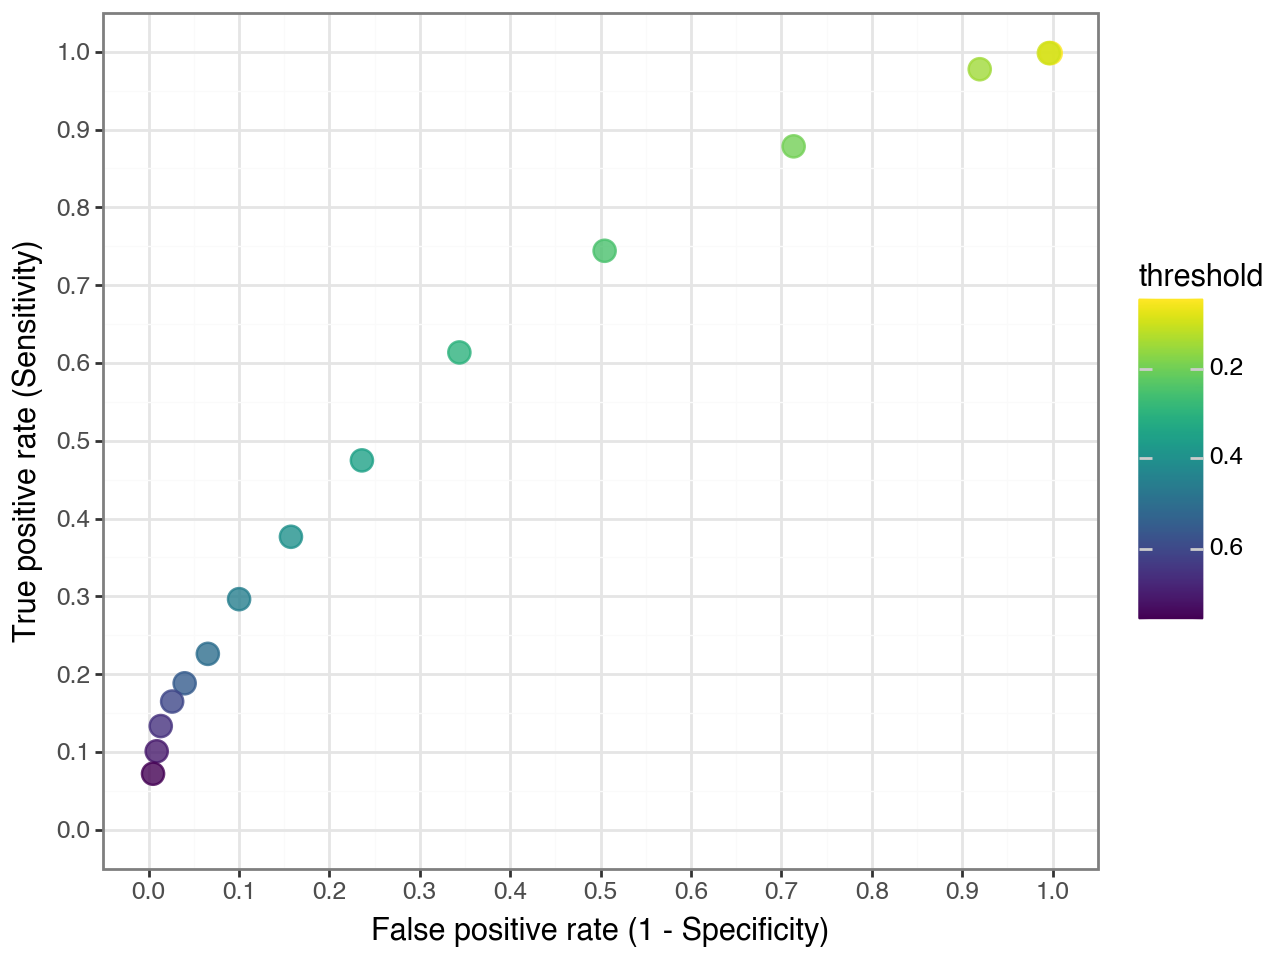

In [122]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

Continuous ROC on holdout with best model

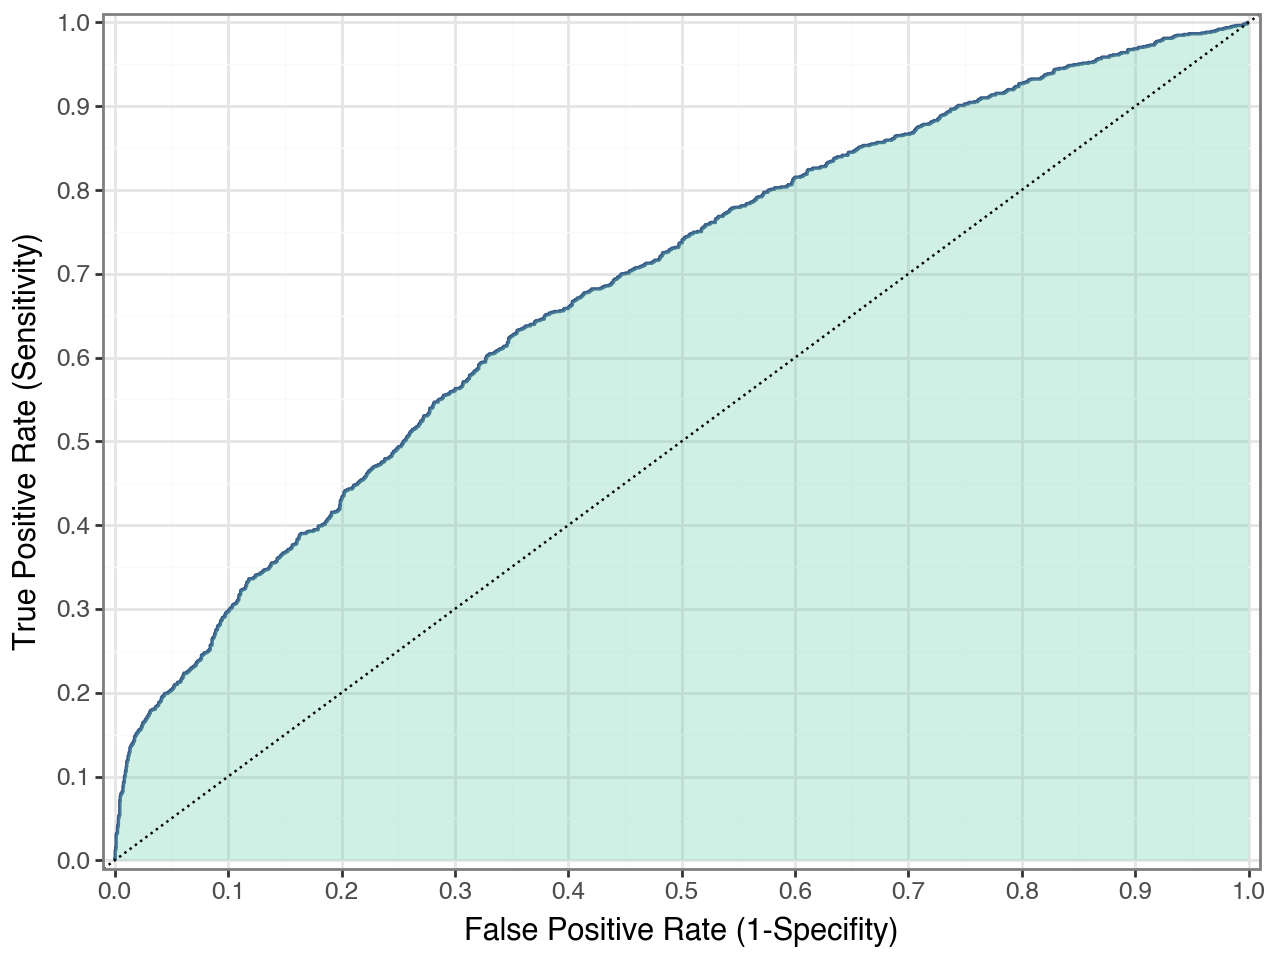

In [123]:
create_roc_plot(data_holdout["HG_turnover"], data_holdout["best_logit_pred_proba"])

The **discrete ROC plot** highlights how different classification thresholds impact the trade-off between true and false positives, while the **continuous ROC curve** confirms that the model consistently performs better than random guessing across all thresholds. This supports the reliability for classification.

## Classification & Loss Function

In this analysis, we adopt the perspective of a risk-tolerant investor who values capturing high-growth opportunities, even at the risk of occasional misclassifications.

### Finding the optimal classification threshold

For each model, we first predict probabilities, then search for the best classification threshold by minimizing expected loss. 

Instead of using a fixed cutoff like 0.5, we adjust the threshold to reflect the cost of mistakes. In our case, missing a high-growth firm (false negative) is much costlier than backing a low-growth one (false positive). This approach helps align model decisions with investor priorities, where the opportunity cost of missing potential winners is high.

In [124]:
FP = 1
FN = 4
cost = FN / FP

**Intuition:** From a corporate finance perspective, fast growth typically reflects the presence of strong reinvestment capabilities, increasing returns to scale, or strategic expansion opportunities. For example for investors, the opportunity cost of missing a high-growth firm often outweighs the loss from investing in a low-growth one, thus motivating our asymmetric loss function in the classification task.

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [125]:
prevelance = y_train.sum() / len(y_train)

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [126]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("HG_turnover ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["HG_turnover"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In the end, each model will be evaluated using four metrics: **RMSE** (overall prediction error), **AUC** (ranking quality of predicted probabilities), **Optimal threshold** (chosen to minimize expected loss), **Expected loss** (based on asymmetric cost of false negatives and false positives).

Expected loss is the most decision-relevant metric because it incorporates the asymmetric costs of false positives and false negatives. Unlike RMSE or AUC, it links model performance directly to real-world consequences, enabling cost-sensitive model selection.

In [127]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [128]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.200771,0.201370,0.672017,0.677883
1,M2,0.213057,0.172817,0.663537,0.669120
2,M3,0.194024,0.211113,0.645736,0.651945
3,M4,0.212004,0.198559,0.642862,0.644585
4,M5,0.193520,0.198828,0.640690,0.640379
5,LASSO,0.210698,0.203597,0.640759,0.633368


Create loss plot based on Fold5 in CV 

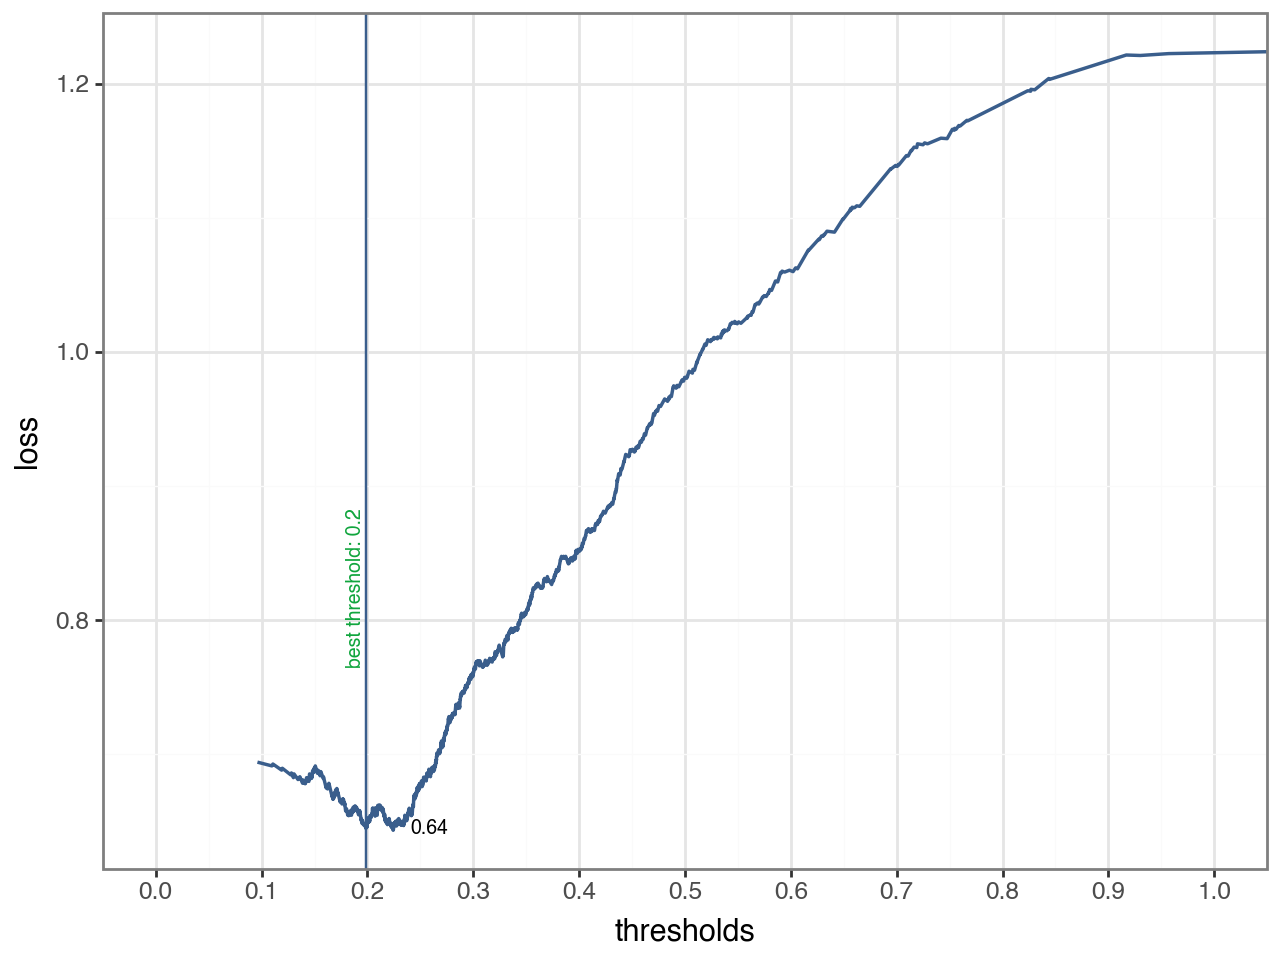

In [129]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

This plot supports our decision to move away from the default 0.5 threshold and instead use a lower, loss-minimizing threshold, which better reflects the higher cost of false negatives in our setting.

Create roc plot plot based on Fold5 in CV

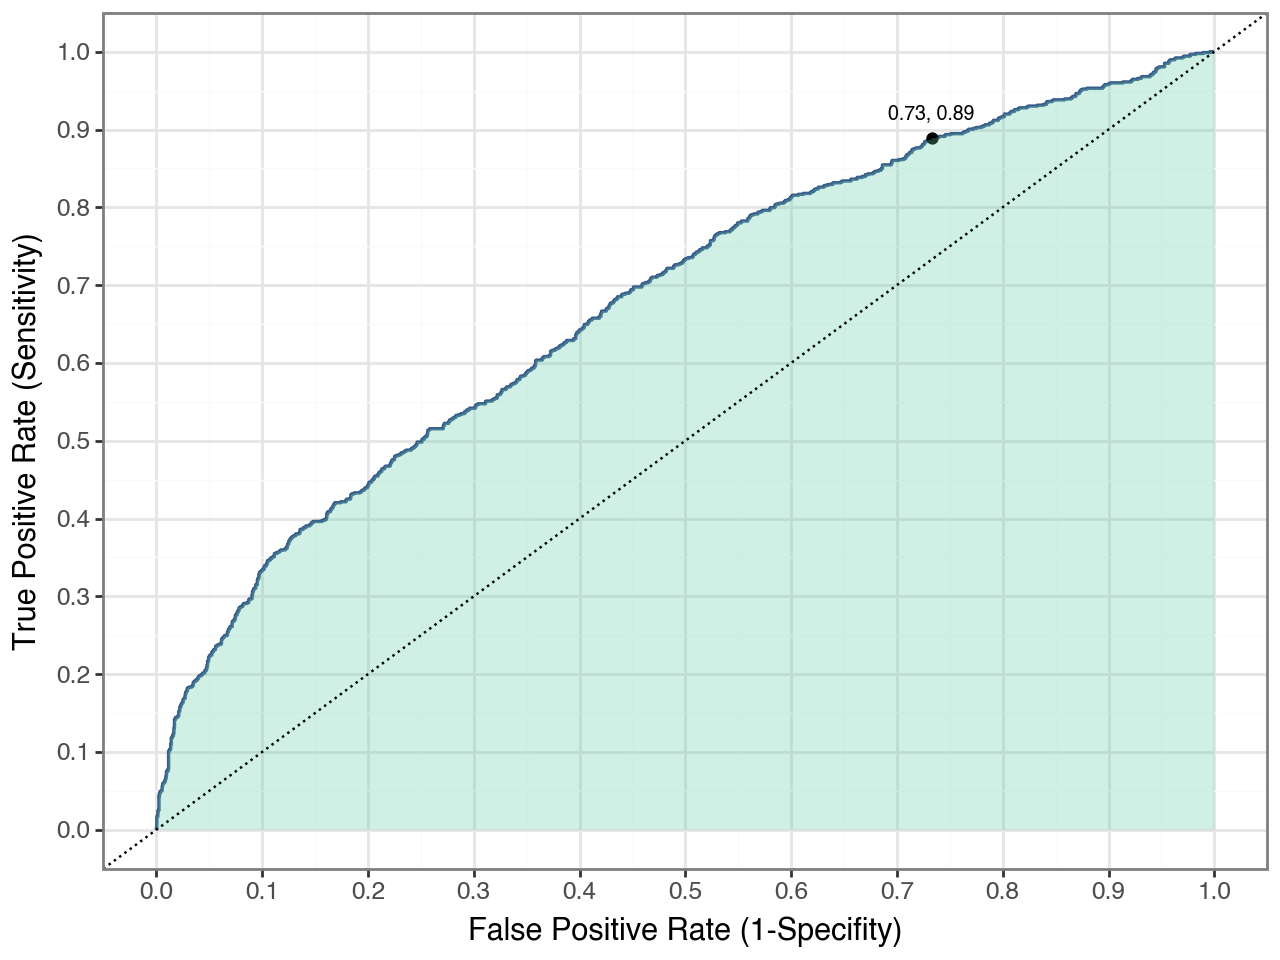

In [130]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


This ROC curve illustrates the trade-off between sensitivity and false positive rate for the model across all thresholds. More specifically, the highlighted point shows that at this point the model captures 89% of true positives, but at the cost of a 73% false positive rate. This may be acceptable in high-risk-tolerant settings, where capturing high-growth firms is more important than avoiding false alarms. This coincides with the assumption we have made.


Let's see our chosen model, M4's holdout expected loss

In [131]:
best_logit_optimal_threshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_threshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_threshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["HG_turnover"], holdout_threshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["HG_turnover"])
round(expected_loss_holdout, 3)

0.639

CM on holdout

In [132]:
cm_object3 = confusion_matrix(data_holdout["HG_turnover"], holdout_threshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)
cm3

,Predicted non-HG,Predicted HG
Actual non-HG,839,1619
Actual HG,165,945


# PREDICTION WITH RANDOM FOREST

In [133]:
y_train, rfvars_train = patsy.dmatrices("HG_turnover~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("HG_turnover~" + "+".join(rfvars), data_holdout)

## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [134]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [135]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [136]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [137]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.676994,0.438757
1,5,16,0.676853,0.438557
2,6,11,0.677191,0.438710
3,6,16,0.675727,0.438826
4,7,11,0.673880,0.439405
5,7,16,0.675949,0.438886


Obtain optimal parameter values

In [138]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 6, 'min_samples_split': 11}

Get average (ie over the folds) RMSE and AUC

In [139]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [140]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,16.0,0.452987,0.618541
M2,23.0,0.447289,0.651345
M3,40.0,0.442029,0.672425
M4,83.0,0.439566,0.676471
M5,197.0,0.440077,0.676408
LASSO,101.0,0.439519,0.677835
RF,n.a.,0.438710,0.677191


Extract fold level RMSE and AUC

In [141]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [142]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.453674,0.448324,0.441399,0.439223,0.439766,0.440585,0.439387
1,0.453006,0.447705,0.443118,0.440257,0.440562,0.439641,0.440070
2,0.456544,0.449611,0.447823,0.444704,0.446635,0.445160,0.440522
3,0.451503,0.445823,0.439853,0.437845,0.438358,0.437867,0.438725
4,0.450207,0.444982,0.437950,0.435802,0.435067,0.434342,0.434049


In [143]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.617237,0.647823,0.676916,0.679032,0.675268,0.671822,0.669827
1,0.614185,0.644926,0.665712,0.672574,0.671504,0.675695,0.665479
2,0.619402,0.656878,0.663630,0.666616,0.663469,0.667086,0.682116
3,0.624016,0.659394,0.681763,0.684280,0.687007,0.687960,0.679275
4,0.617864,0.647703,0.674102,0.679852,0.684794,0.686610,0.689256


Now use loss function and search for best thresholds and expected loss over folds 

In [144]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["HG_turnover"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["HG_turnover"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [145]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [146]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.439,0.677,0.201,0.206,0.643,0.628


Create plots based on Fold5 in CV 

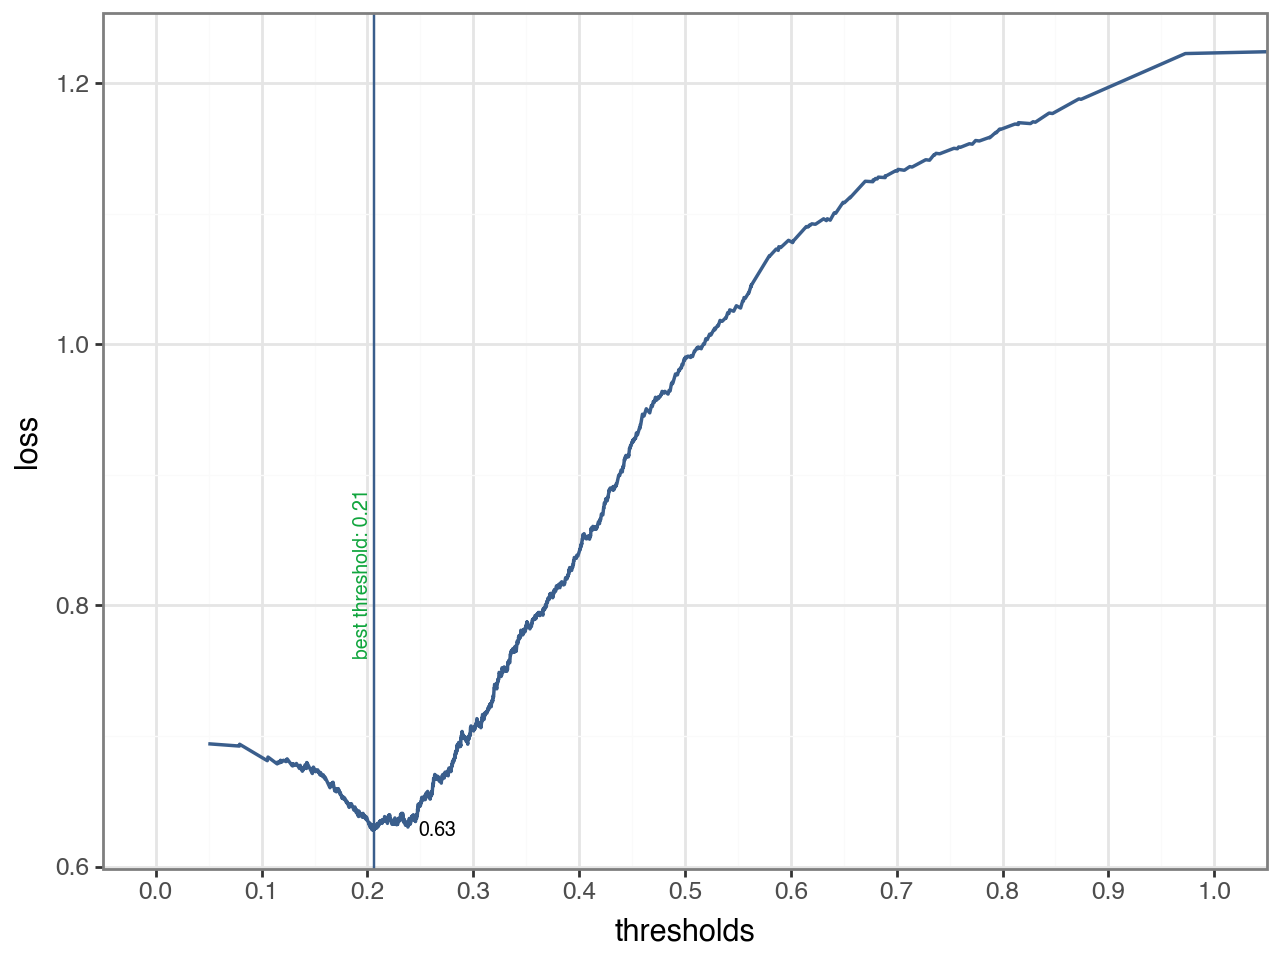

In [147]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

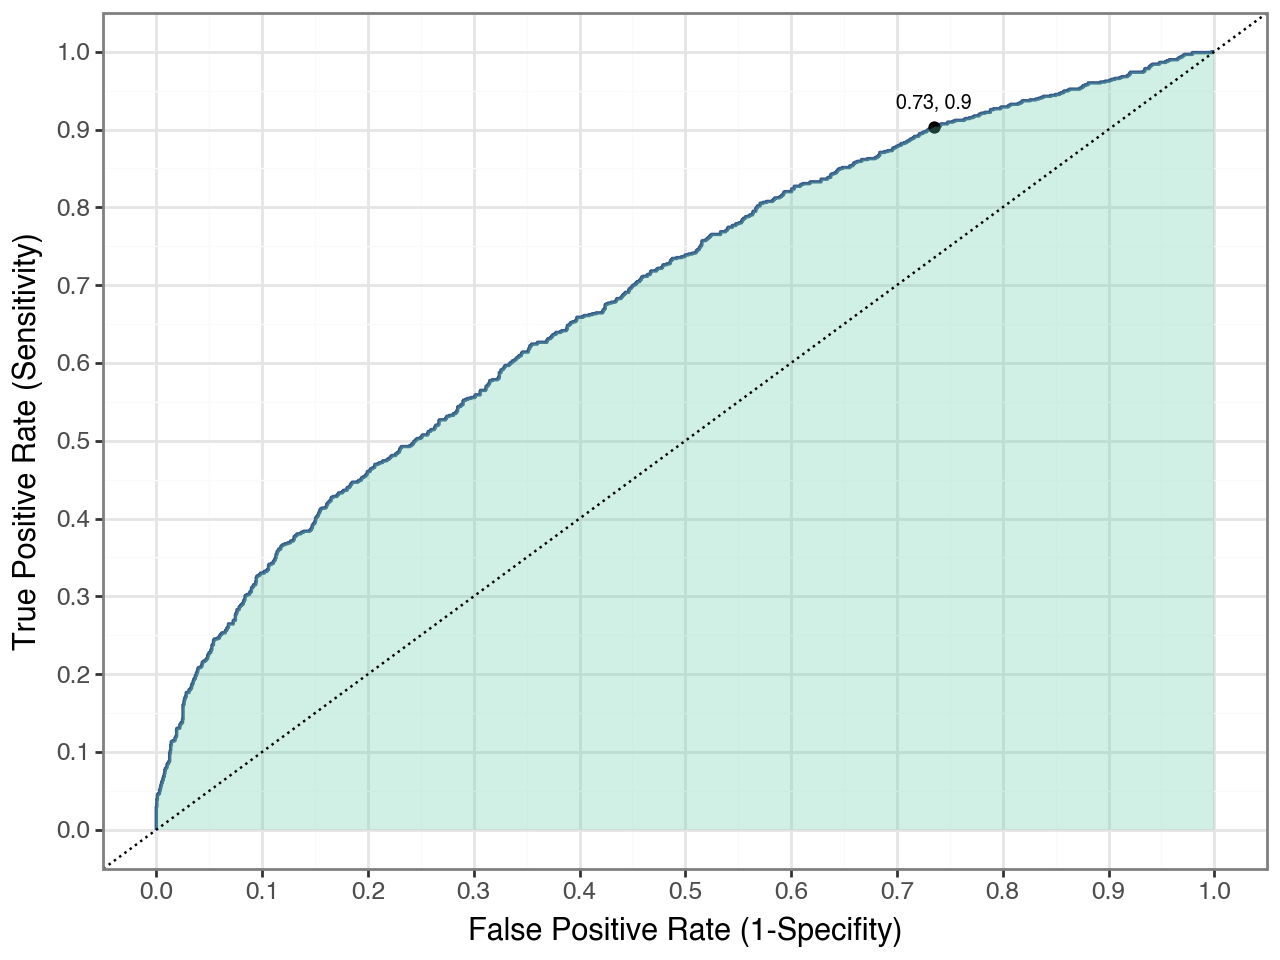

In [148]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [149]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.437

ROC AUC  on holdout

In [150]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.677

 Get expected loss on holdout

In [151]:
holdout_threshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_threshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.646

In [152]:
summary["CV threshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [153]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV threshold,CV expected Loss
M1,16.0,0.452987,0.618541,0.200771,0.672017
M2,23.0,0.447289,0.651345,0.213057,0.663537
M3,40.0,0.442029,0.672425,0.194024,0.645736
M4,83.0,0.439566,0.676471,0.212004,0.642862
M5,197.0,0.440077,0.676408,0.193520,0.640690
LASSO,101.0,0.439519,0.677835,0.210698,0.640759
RF,n.a.,0.438710,0.677191,0.200581,0.642791


## Gradient Boosting

In [154]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [155]:
gbm = GradientBoostingClassifier(
    learning_rate=0.1, min_samples_split=20, random_state=42
)

# Smaller, faster hyperparameter grid
tune_grid = {"n_estimators": [200, 300], "max_depth": [3, 5]}

# Faster grid search: fewer CV folds, still parallelized
gbm_model_cv = GridSearchCV(
    estimator=gbm,
    param_grid=tune_grid,
    cv=5, 
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [156]:
firm_num = ["age", "age2", "new"] 
firm_cat= ["ind2_cat", "m_region_loc", "urban_m"]
data.rename(columns={col: f"f_{col}" for col in firm_cat}, inplace=True)
firm_cat_f = ["f_ind2_cat", "f_m_region_loc", "f_urban_m"]

gbrvars = ["sales_mil_log", "sales_mil_log_sq"] + rawvars + hr + firm_num + firm_cat_f + qualityvars

data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [157]:
# Define gbrvars with the appropriate list of predictor variable names

categorical_columns = [col for col in gbrvars if col.startswith("f_")]
numerical_columns = [col for col in gbrvars if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [158]:
gbm_pipe.fit(data_train[gbrvars], data_train.HG_turnover)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 2/4] START max_depth=3, n_estimators=300...............................
[CV 2/5; 1/4] START max_depth=3, n_estimators=200...............................
[CV 5/5; 1/4] START max_depth=3, n_estimators=200...............................
[CV 3/5; 2/4] START max_depth=3, n_estimators=300...............................
[CV 4/5; 1/4] START max_depth=3, n_estimators=200...............................
[CV 2/5; 2/4] START max_depth=3, n_estimators=300...............................
[CV 1/5; 1/4] START max_depth=3, n_estimators=200...............................
[CV 3/5; 1/4] START max_depth=3, n_estimators=200...............................
[CV 1/5; 1/4] END max_depth=3, n_estimators=200;, score=-0.523 total time=  16.1s
[CV 2/5; 1/4] END max_depth=3, n_estimators=200;, score=-0.535 total time=  16.1s
[CV 5/5; 1/4] END max_depth=3, n_estimators=200;, score=-

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_ind2_cat',
                                                   'f_m_region_loc',
                                                   'f_urban_m']),
                                                 ('num', 'passthrough',
                                                  ['sales_mil_log',
                                                   'sales_mil_log_sq',
                                                   'curr_assets', 'curr_liab',
                                                   'extra_exp', 'extra_inc',
                                                   'extra_profit_loss',
                                                   'fixed_assets',
                                                   'inc_bef_tax',
                                                   'intang_assets',
                                                   'inventories', 'liq_assets...
                                                   'flag_miss_ceo_age',
                                                   'ceo_count', 'labor_avg_mod',
                                                   'flag_miss_labor_avg',
                                                   'foreign_management', 'age',
                                                   'age2', 'new', ...])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingClassifier(min_samples_split=20,
                                                                   random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [3, 5],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [159]:
gbm_rmse = gbm_pipe.steps[-1][1].best_score_ * -1
gbm_rmse

0.528249884706404

In [160]:
from sklearn.model_selection import cross_val_score

# Extract the preprocessing and best regressor from the pipeline
best_gbm = gbm_pipe.named_steps["regressor"].best_estimator_

# Recreate a simplified pipeline (no GridSearch) for CV AUC scoring
from sklearn.pipeline import make_pipeline

gbm_final_pipe = make_pipeline(preprocessing, best_gbm)

# Cross-validate AUC
cv_auc_gbm = cross_val_score(
    gbm_final_pipe,
    data_train[gbrvars],
    data_train["HG_turnover"],
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

# Final average CV AUC
cv_auc_gbm_mean = cv_auc_gbm.mean()

In [161]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, confusion_matrix

expected_loss_gbm = []
best_thresholds_gbm = []

# Split into features and target
X = data_train[gbrvars]
y = data_train["HG_turnover"]

# Get preprocessed data
X_preprocessed = preprocessing.fit_transform(X)

# Explicit CV splitter
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# CV loop
for train_idx, test_idx in cv_splitter.split(X_preprocessed, y):
    X_train_fold = X_preprocessed[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_test_fold = X_preprocessed[test_idx]
    y_test_fold = y.iloc[test_idx]

    # Fit best classifier model
    gbm_fold_model = GradientBoostingClassifier(
    **gbm_pipe.named_steps["regressor"].best_params_,
    learning_rate=0.1,
    min_samples_split=20,
    random_state=42,
)
    gbm_fold_model.fit(X_train_fold, y_train_fold)

    # Predict probabilities (works now with classifier)
    y_pred_prob = gbm_fold_model.predict_proba(X_test_fold)[:, 1]

    # Get optimal threshold using your loss function
    fpr, tpr, thresholds = roc_curve(y_test_fold, y_pred_prob)
    best_thresh = sorted(
        list(
            zip(
                np.abs(
                    tpr + (1 - prevelance) / (cost * prevelance) * (1 - fpr)
                ),
                thresholds,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]

    best_thresholds_gbm.append(best_thresh)
    predictions = (y_pred_prob >= best_thresh).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test_fold, predictions, labels=[0, 1]).ravel()
    loss = (fp * FP + fn * FN) / len(y_test_fold)
    expected_loss_gbm.append(loss)

# Save averages
best_thresholds_cv["GBM"] = np.mean(best_thresholds_gbm)
expected_loss_cv["GBM"] = np.mean(expected_loss_gbm)


### Take best model and estimate RMSE on holdout  CHECK WITH AYAZHAN - why M4 here?

  - M4 and LASSO perform very similarly.
  - M4 uses **fewer coefficients** than LASSO or M5, which makes it easier to interpret.
- Compared to simpler models like M1 or M2, M4 provides significantly better predictive performance, especially in terms of AUC (discrimination ability).

#### ✅ Conclusion:

We choose **M5** as our final model. It delivers **high predictive accuracy** while maintaining a **manageable number of features**, making it a practical and interpretable choice for identifying high-growth firms.

## Discussion of Results

### Model Performance: RMSE, AUC, Threshold, and Expected Loss

While AUC values were broadly similar—indicating that all models ranked firms reasonably well—the expected loss was the most important criterion, as it directly captures the business cost of classification errors under the asymmetric loss function.

Logit M5 emerged as the most effective model overall, striking a strong balance between predictive performance and interpretability. Random Forest also performed well, especially in terms of probability accuracy, reflected in its low RMSE, but it lacked the interpretability of Logit models. Gradient Boosting had a comparable AUC but suffered from poorer RMSE performance, likely due to limited tuning, which affected its calibration.

The optimal classification thresholds for all models were notably lower than the default, reinforcing the idea that a lower cutoff is appropriate when the cost of false negatives outweighs that of false positives. 


In [162]:
summary.loc["GBM", "CV RMSE"] = round(gbm_rmse, 3)
summary.loc["GBM", "CV AUC"] = round(cv_auc_gbm_mean, 3)
summary.loc["GBM", "CV threshold"] = round(best_thresholds_cv["GBM"], 3)
summary.loc["GBM", "CV expected Loss"] = round(expected_loss_cv["GBM"], 3)

summary

,Number of Coefficients,CV RMSE,CV AUC,CV threshold,CV expected Loss
M1,16.0,0.452987,0.618541,0.200771,0.672017
M2,23.0,0.447289,0.651345,0.213057,0.663537
M3,40.0,0.442029,0.672425,0.194024,0.645736
M4,83.0,0.439566,0.676471,0.212004,0.642862
M5,197.0,0.440077,0.676408,0.193520,0.640690
LASSO,101.0,0.439519,0.677835,0.210698,0.640759
RF,n.a.,0.438710,0.677191,0.200581,0.642791
GBM,NaN,0.528000,0.676000,0.192000,0.644000


### Confusion matrix

We use a confusion matrix on the holdout set to evaluate the Logit M5 model at the optimal threshold from Fold 5. This threshold minimizes the expected loss based on our custom investor-oriented loss function, which penalizes false negatives more heavily.


The confusion matrix clearly illustrates how the model balances false positives and false negatives, offering insight into real-world performance beyond metrics like AUC.

In this context, a false negative means failing to identify a firm that will grow rapidly — a costly mistake for an investor who seeks high-return opportunities.
We assume that missing a high-growth firm is more harmful than backing one that does not grow. For this reason, our loss function places greater weight on false negatives.


In [163]:
# Ensure 'best_logit_pred_proba' exists in the DataFrame
if "best_logit_pred_proba" not in data_holdout.columns:
    data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

# Generate predictions for the holdout set using the optimal threshold for M5
holdout_predictions_m5 = np.where(
    data_holdout["best_logit_pred_proba"] < summary_with_lossfnc.loc[4, "Threshold for Fold5"], 0, 1
)

# Create the confusion matrix
cm_object_m5 = confusion_matrix(data_holdout["HG_turnover"], holdout_predictions_m5, labels=[0, 1])

# Convert the confusion matrix to a DataFrame for better readability
cm_m5 = pd.DataFrame(
    cm_object_m5,
    index=["Actual non-HG", "Actual HG"],
    columns=["Predicted non-HG", "Predicted HG"],
)

cm_m5

,Predicted non-HG,Predicted HG
Actual non-HG,691,1767
Actual HG,134,976


### Model Results and Usefulness

Based on the summary table and the confusion matrix, Logit M5 emerged as the best model overall, offering the lowest expected loss and a strong balance between prediction accuracy and interpretability.  
Random Forest and Gradient Boosting also performed well, though RF showed slightly better results than GBM, likely due to limited hyperparameter tuning in the latter.  
The chosen models are particularly useful in high-risk-tolerant environments, where missing a high-growth firm is costlier than mistakenly investing in a low-growth one.

Overall, the models provide valuable decision support for investors or policymakers aiming to identify high-growth firms. Their usefulness depends on the user’s risk preferences. In our case, we prioritize capturing high-growth opportunities even at the cost of some false positives, acknowledging the trade-off between potential gains and occasional misclassification.


# Part 2: Sector Comparison

To assess model performance across sectors, we applied it separately to manufacturing and services firms, using a consistent loss function and evaluation framework. Random Forest was selected as the final model for its strong predictive accuracy, robustness to overfitting, and relatively low computational demands during tuning.

## Import data

In [164]:
# !!! assignment-3-prep.ipynb should be run first

# Import data
csv_path = os.path.join(output, "2012_hg_workfile_M.csv")

# Read the CSV file
data = pd.read_csv(csv_path)

## Define helper functions

In [165]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot


In [166]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [167]:
print("Total")
print(data["HG_turnover"].value_counts(normalize=True))
print("Train")
print(data["HG_turnover"].value_counts(normalize=True))
print("Holdout")
print(data["HG_turnover"].value_counts(normalize=True))

Total
HG_turnover
0    0.685175
1    0.314825
Name: proportion, dtype: float64
Train
HG_turnover
0    0.685175
1    0.314825
Name: proportion, dtype: float64
Holdout
HG_turnover
0    0.685175
1    0.314825
Name: proportion, dtype: float64


In [168]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

In [169]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]


In [170]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [171]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

In [172]:
rfvars = ["sales_mil_log", "sales_mil_log_sq"] + rawvars + hr + firm + qualityvars

In [173]:
y_train, rfvars_train = patsy.dmatrices("HG_turnover~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("HG_turnover~" + "+".join(rfvars), data_holdout)

## The loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)


In [174]:
FP = 1
FN = 4
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [175]:
prevelance = y_train.sum() / len(y_train)

## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [176]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [177]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

In [178]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [179]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [180]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.613108,0.455124
1,5,16,0.616903,0.454470
2,6,11,0.611186,0.455933
3,6,16,0.614566,0.455164
4,7,11,0.611617,0.455835
5,7,16,0.612785,0.455536


Obtain optimal parameter values

In [181]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}

Get average (ie over the folds) RMSE and AUC

In [182]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [183]:
prob_forest_best_results

,max_features,min_samples_split,cv_auc,cv_rmse
1,5,16,0.616903,0.45447


Extract fold level RMSE and AUC

In [184]:
CV_RMSE_folds = dict()
CV_AUC_folds = dict()

CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

In [185]:
# Initialize combined performance dictionary
cv_metrics = {}

# Extract RMSE (based on Brier score)
rmse_rf = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)

# Extract AUC
auc_rf = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

# Add to combined dictionary
cv_metrics["RF"] = {
    "RMSE": rmse_rf,
    "AUC": auc_rf
}


Take a look at foldwise RMSE and AUC

In [186]:
pd.DataFrame(cv_metrics)

,RF
RMSE,"[0.4523667283232945, 0.453646024914361, 0.4467..."
AUC,"[0.6115586174409704, 0.6470680044593089, 0.620..."


In [187]:
# Create fold-level DataFrame from the RF metrics
rf_metrics_df = pd.DataFrame({
    "Fold": np.arange(1, 1 + len(cv_metrics["RF"]["RMSE"])),
    "RMSE": cv_metrics["RF"]["RMSE"],
    "AUC": cv_metrics["RF"]["AUC"]
})

# Set fold number as index
rf_metrics_df = rf_metrics_df.set_index("Fold")

# Display the result
print(rf_metrics_df)


          RMSE       AUC
Fold                    
1     0.452367  0.611559
2     0.453646  0.647068
3     0.446755  0.620502
4     0.457983  0.607019
5     0.461462  0.598367


Now use loss function and search for best thresholds and expected loss over folds 

In [188]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["HG_turnover"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["HG_turnover"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [189]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [190]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.454,0.617,0.176,0.156,0.658,0.657


Create plots based on Fold5 in CV 

### Classification Threshold Optimization – Manufacturing Sector

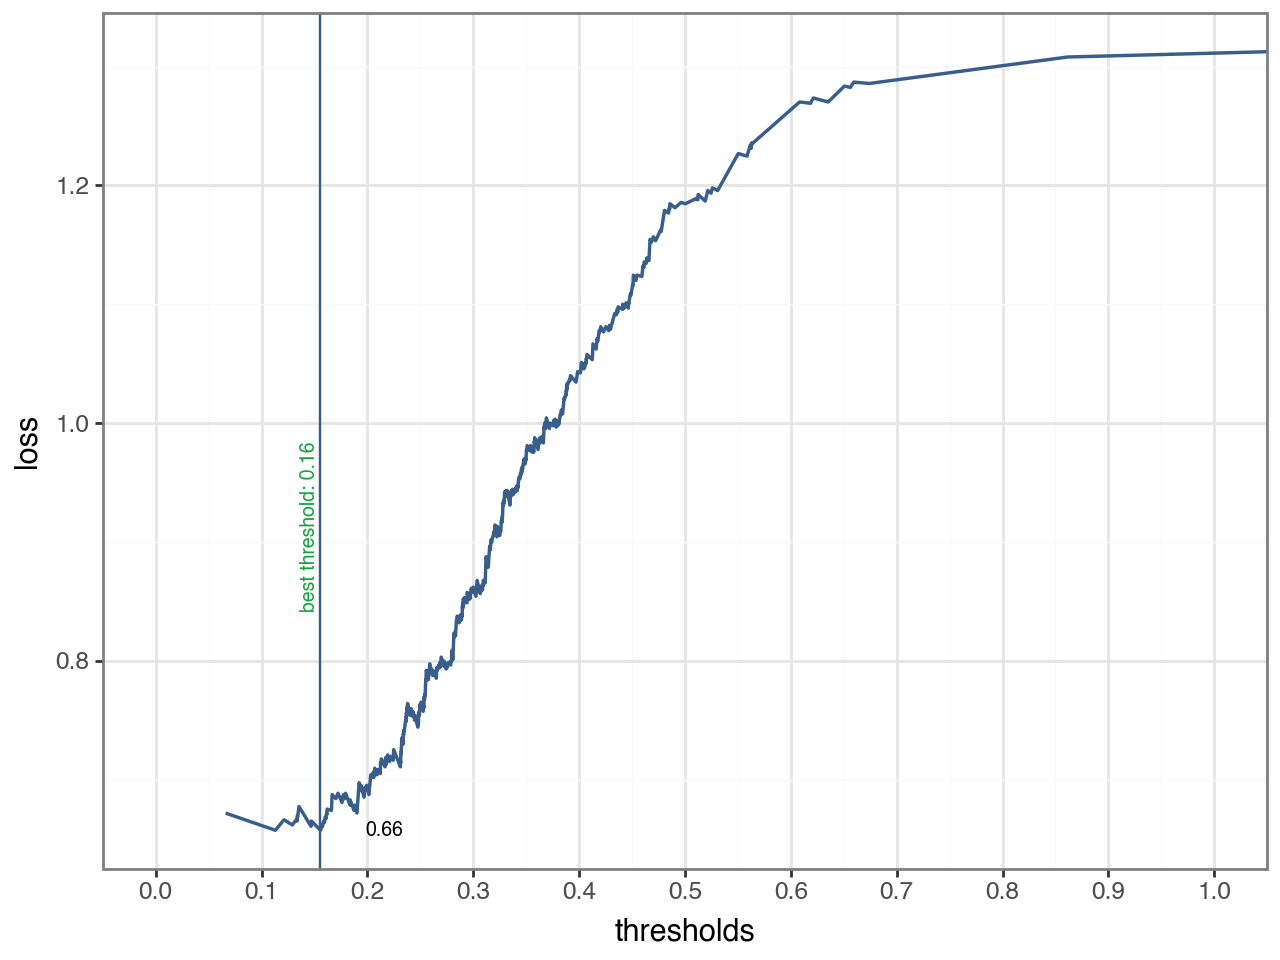

In [191]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

The plot above shows the relationship between classification thresholds and expected loss for the Random Forest model applied to the manufacturing subsample. The x-axis represents the probability threshold used to classify firms as high-growth, and the y-axis shows the corresponding expected loss based on our custom loss function (False Positive = 1, False Negative = 4).

The curve displays a shallow U-shape, with the lowest expected loss occurring around a threshold of 0.16 (highlighted by the vertical line). Beyond this point, the loss increases more steeply, particularly at higher thresholds. This indicates that misclassification costs grow rapidly when the model becomes too conservative. The selected threshold provides the best trade-off between capturing high-growth firms and minimizing false positives, in line with our investor-driven loss function where false negatives are more costly.

### ROC Curve – Fold 5 (Random Forest, Manufacturing)

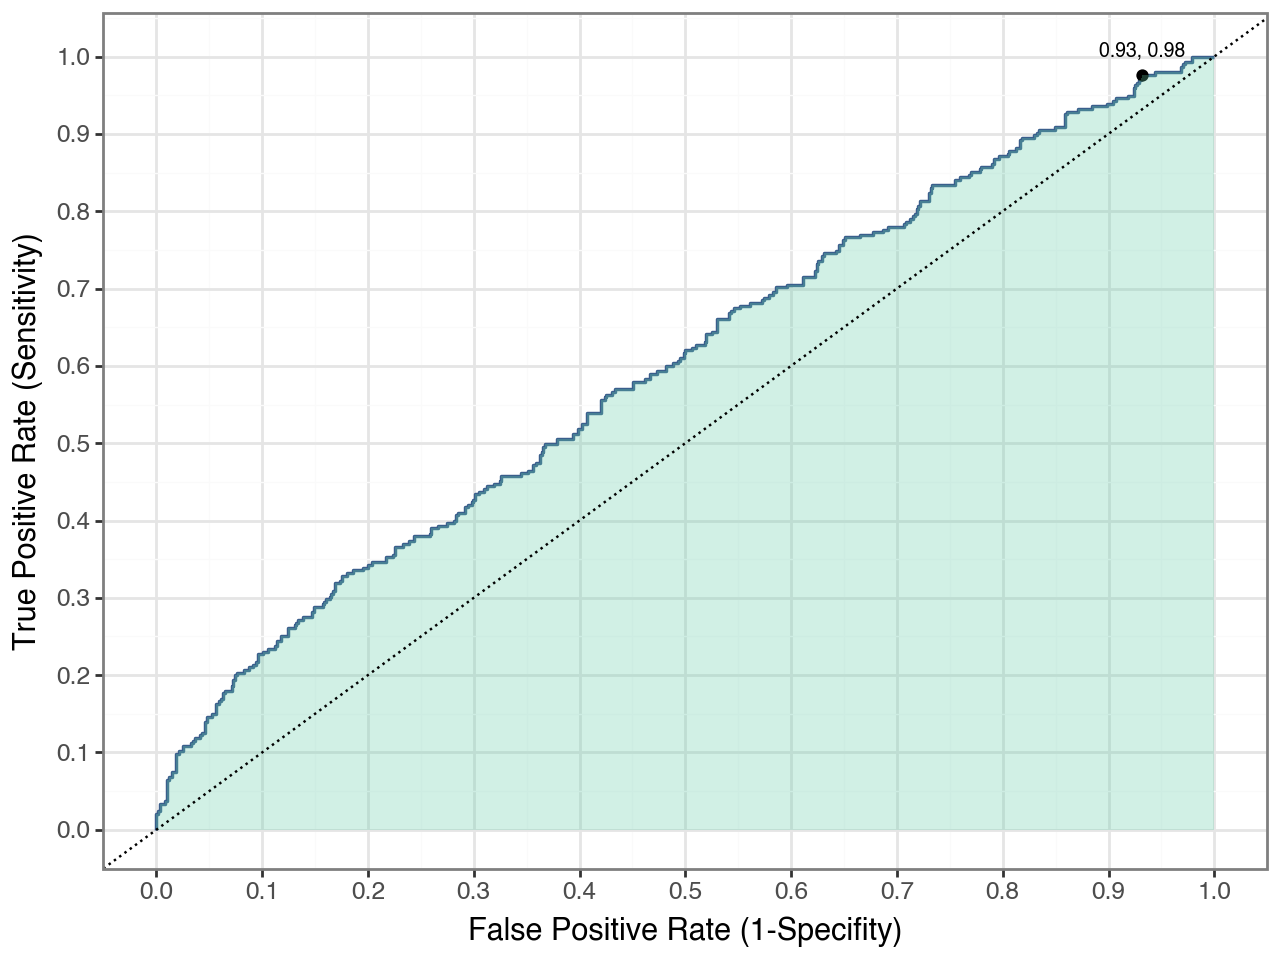

In [192]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

The ROC curve lies above the diagonal baseline, confirming that the model performs better than random guessing.

While the AUC is moderate, the steep initial slope indicates that the model correctly identifies a significant share of high-growth firms at low false positive rates. This is desirable in our context, where identifying high-growth firms (true positives) is economically more valuable than avoiding false positives. The marked point shows the selected optimal threshold for Fold 5, which minimizes expected loss under the investor-weighted loss function.

Take model to holdout and estimate RMSE, AUC and expected loss 

In [193]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.449

ROC AUC  on holdout

In [194]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.634

 Get expected loss on holdout

In [195]:
holdout_threshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_threshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.686

## Final results

In [196]:
summary = dict()
summary["CV threshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [197]:
summary

{'CV threshold': {'RF': 0.17552208608893896},
 'CV expected Loss': {'RF': 0.6576195773081202}}

In [198]:
#To compare the results of the RF modeling on `2012_hg_workfile_S.csv` with the previous results, we need to repeat the RF modeling steps for the new dataset (`2012_hg_workfile_S.csv`) and then compare the key metrics such as CV RMSE, CV AUC, thresholds, and expected loss.

# Load the new dataset
csv_path_s = os.path.join(output, "2012_hg_workfile_S.csv")
data_s = pd.read_csv(csv_path_s)

In [199]:
#2. **Split the data into training and holdout sets**:
data_train_s, data_holdout_s = train_test_split(data_s, train_size=0.8, random_state=42)

In [200]:
#3. **Prepare the variables for modeling**:
y_train_s, rfvars_train_s = patsy.dmatrices("HG_turnover~" + "+".join(rfvars), data_train_s)
y_holdout_s, rfvars_holdout_s = patsy.dmatrices("HG_turnover~" + "+".join(rfvars), data_holdout_s)

In [201]:
# 4. **Perform RF modeling with cross-validation**:
  #  Reuse the grid, `KFold`, and `GridSearchCV` setup from the previous modeling steps:
prob_forest_fit_s = prob_forest_grid.fit(rfvars_train_s, y_train_s)

In [202]:
# Extract the cross-validation results for the new dataset
prob_forest_cv_results_s = pd.DataFrame(
        {
            "max_features": prob_forest_fit_s.cv_results_["param_max_features"],
            "min_samples_split": prob_forest_fit_s.cv_results_["param_min_samples_split"],
            "cv_auc": prob_forest_fit_s.cv_results_["mean_test_roc_auc"],
            "cv_rmse": np.sqrt(
                prob_forest_fit_s.cv_results_["mean_test_neg_brier_score"] * -1
            ),
        }
    )

In [203]:
# Identify the best results based on the optimal parameters
prob_forest_best_results_s = prob_forest_cv_results_s[
        (prob_forest_cv_results_s.max_features == prob_forest_fit_s.best_params_["max_features"])
        & (prob_forest_cv_results_s.min_samples_split == prob_forest_fit_s.best_params_["min_samples_split"])
]

In [204]:
# Calculate thresholds and expected loss for the new dataset
best_thresholds_s = list()
expected_loss_s = list()

    # Loop through the folds to calculate metrics
for train_index, test_index in k.split(rfvars_train_s):
        X_fold_s = pd.DataFrame(rfvars_train_s).iloc[test_index, :]
        y_fold_s = data_train_s["HG_turnover"].iloc[test_index]

        X_fold_train_s = pd.DataFrame(rfvars_train_s).iloc[train_index, :]
        y_fold_train_s = data_train_s["HG_turnover"].iloc[train_index]

        # Train the Random Forest model on the current fold
        prob_forest_best_s = RandomForestClassifier(
            random_state=42,
            n_estimators=500,
            oob_score=True,
            criterion="gini",
            max_features=prob_forest_fit_s.best_params_["max_features"],
            min_samples_split=prob_forest_fit_s.best_params_["min_samples_split"],
        )
        prob_forest_best_fold_s = prob_forest_best_s.fit(X_fold_train_s, y_fold_train_s)
        pred_fold_s = prob_forest_best_fold_s.predict_proba(X_fold_s)[:, 1]

        # Calculate the ROC curve and find the best threshold
        false_pos_rate_s, true_pos_rate_s, threshold_s = roc_curve(y_fold_s, pred_fold_s)
        best_threshold_s = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate_s
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate_s)
                    ),
                    threshold_s,
                )
            ),
            key=lambda x: x[0],
            reverse=True,
        )[0][1]
        best_thresholds_s.append(best_threshold_s)

        # Calculate expected loss for the current fold
        threshold_prediction_s = np.where(pred_fold_s < best_threshold_s, 0, 1)
        tn_s, fp_s, fn_s, tp_s = confusion_matrix(
            y_fold_s, threshold_prediction_s, labels=[0, 1]
        ).ravel()
        curr_exp_loss_s = (fp_s * FP + fn_s * FN) / len(y_fold_s)
        expected_loss_s.append(curr_exp_loss_s)

### Comparison of the results for 2 samples (manufacturing vs. services)

In [205]:
# Store the average threshold and expected loss across folds
best_thresholds_cv_s = dict()
expected_loss_cv_s = dict()
expected_loss_cv_s["RF"] = np.mean(expected_loss_s)
best_thresholds_cv_s["RF"] = np.mean(best_thresholds_s)

    # Create a summary table comparing the metrics from both datasets
comparison_summary = pd.DataFrame(
        {
            "Metric": ["CV RMSE", "CV AUC", "Avg Threshold", "Avg Expected Loss"],
            "2012_hg_workfile_M": [
                round(prob_forest_best_results["cv_rmse"].values[0], 3),
                round(prob_forest_best_results["cv_auc"].values[0], 3),
                round(best_thresholds_cv["RF"], 3),
                round(expected_loss_cv["RF"], 3),
            ],
            "2012_hg_workfile_S": [
                round(prob_forest_best_results_s["cv_rmse"].values[0], 3),
                round(prob_forest_best_results_s["cv_auc"].values[0], 3),
                round(best_thresholds_cv_s["RF"], 3),
                round(expected_loss_cv_s["RF"], 3),
            ],
        }
    )

    # Display the comparison summary
comparison_summary

,Metric,2012_hg_workfile_M,2012_hg_workfile_S
0,CV RMSE,0.454,0.433
1,CV AUC,0.617,0.700
2,Avg Threshold,0.176,0.204
3,Avg Expected Loss,0.658,0.622


The table above compares model performance between manufacturing (_M) and services (_S) sectors using the same prediction model (Random Forest) and consistent evaluation criteria.

The services sector shows better predictive performance, with a lower RMSE (0.433 vs. 0.454) and a higher AUC (0.700 vs. 0.617). This suggests that high-growth firms in services are more consistently identified by the general model, which was also run in Part 1.

The expected loss is also lower in services (0.622 vs. 0.658), indicating fewer costly misclassifications under our investor-weighted loss function.

The optimal threshold for classification is higher in services (0.204 vs. 0.176), reflecting different score distributions.

These results may partly reflect differences in sample sizes—the services group includes more than twice as many firms, which likely supports better model learning and generalization. Additionally, services firms tend to exhibit more stable growth patterns compared to the higher variability seen in manufacturing due to investment cycles and capital intensity.